In [279]:
specific = True

folder_path = "clean_loop/no_mod"
if specific:
    paths = ["privacy/no_mod_10", "privacy/no_mod_25", "privacy/no_mod_50", "privacy/no_mod_80"]
    # paths = ["personalization/no_mod_10", "personalization/no_mod_25", "personalization/no_mod_50", "personalization/no_mod_80"]

save = False

In [280]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors
import re
import numpy as np
from matplotlib.ticker import PercentFormatter

In [281]:
files = [f for f in os.listdir(folder_path) if f.endswith('_metrics.csv')]
dfs = []

for file in files:
    filename = os.path.splitext(file)[0]  # remove .csv
    parts = filename.split('_')
    if len(parts) >= 3:
        algorithm = parts[0]
        dataset = parts[1]
    else:
        continue  # skip if filename doesn't match pattern

    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    df['algorithm'] = algorithm.upper()
    df['dataset'] = dataset

    dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

In [282]:
if specific:
    specific_df = pd.DataFrame()
    for specific_path in paths:
        folder_path = specific_path

        files = [f for f in os.listdir(folder_path) if f.endswith('_metrics.csv')]

        dfs = []

        for file in files:
            filename = os.path.splitext(file)[0]  # remove .csv
            parts = filename.split('_')
            if len(parts) >= 3:
                algorithm = parts[0]
                dataset = parts[1]
            else:
                continue  # skip if filename doesn't match pattern

            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)

            df['algorithm'] = algorithm.upper()
            df['dataset'] = dataset
            dfs.append(df)

        merged_df_ex = pd.concat(dfs, ignore_index=True)

        merged_df_ex['delta'] = merged_df_ex['value'] - merged_df['value']

        merged = merged_df_ex.merge(
            merged_df,
            on=['key', 'algorithm', 'dataset'],
            suffixes=('_ex', '_ref')
        )

        # Obliczenie różnicy
        merged['delta'] = merged['value_ex'] - merged['value_ref']
        merged['percent_delta'] = (merged['delta'] / merged['value_ref'])
        merged['percent_delta'] = merged['percent_delta'].fillna(0)
        merged['percent_delta'] = merged['percent_delta'].replace([np.inf], 1)

        match = re.search(r'\d+', specific_path)
        if match:
            number = int(match.group())
        merged['percent'] = number
        
        specific_df = pd.concat([specific_df, merged], ignore_index=True)
    specific_df['percent'] = specific_df['percent'].astype(str) + '%'


In [283]:
specific_df

,key,value_ex,algorithm,dataset,delta,value_ref,percent_delta,percent
0,precision,0.000000,CBF,amazonsales,0.000000,0.000000,0.000000,10%
1,precision_at_k,0.025000,CBF,amazonsales,0.000000,0.025000,0.000000,10%
2,recall,0.000000,CBF,amazonsales,0.000000,0.000000,0.000000,10%
3,recall_at_k,0.025000,CBF,amazonsales,0.000000,0.025000,0.000000,10%
4,mae,1.435999,CBF,amazonsales,-0.005311,1.441310,-0.003685,10%
...,...,...,...,...,...,...,...,...
463,user_coverage,0.065217,RL,postrecommendations,0.021739,0.043478,0.500000,80%
464,item_coverage,0.002244,RL,postrecommendations,0.000748,0.001496,0.500000,80%
465,personalization,0.987817,RL,postrecommendations,-0.000717,0.988533,-0.000725,80%
466,intra_list_similarity,0.017131,RL,postrecommendations,-0.091680,0.108811,-0.842564,80%


In [284]:
specific_df[specific_df['key'] == 'precision']

,key,value_ex,algorithm,dataset,delta,value_ref,percent_delta,percent
0,precision,0.000000,CBF,amazonsales,0.000000,0.000000,0.000000,10%
13,precision,0.060345,CBF,movielens,0.060345,0.000000,1.000000,10%
26,precision,0.021739,CBF,postrecommendations,-0.010450,0.032189,-0.324638,10%
39,precision,0.000000,CF,amazonsales,0.000000,0.000000,0.000000,10%
52,precision,0.250000,CF,movielens,0.000000,0.250000,0.000000,10%
65,precision,0.000000,CF,postrecommendations,0.000000,0.000000,0.000000,10%
78,precision,0.025000,RL,amazonsales,-0.025000,0.050000,-0.500000,10%
91,precision,0.008696,RL,movielens,-0.008696,0.017391,-0.500000,10%
104,precision,0.032609,RL,postrecommendations,-0.010870,0.043478,-0.250000,10%
117,precision,0.000000,CBF,amazonsales,0.000000,0.000000,0.000000,25%


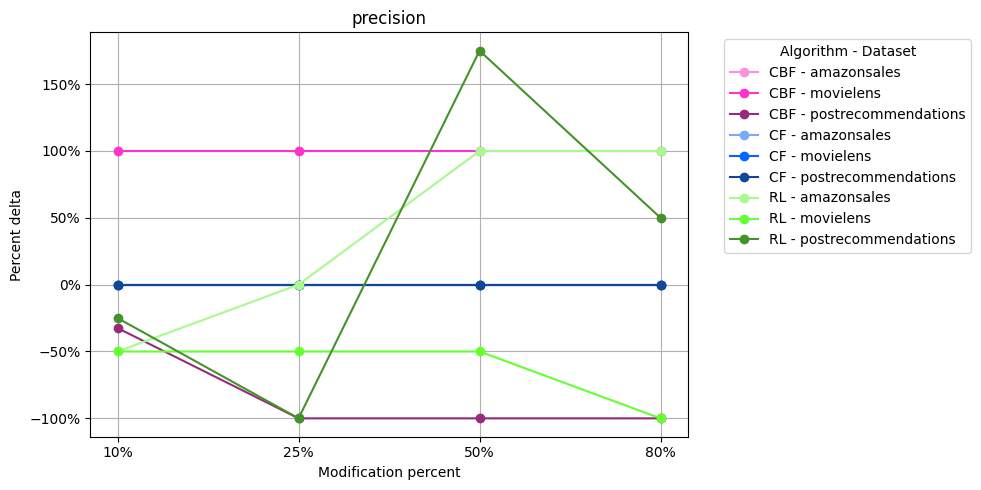

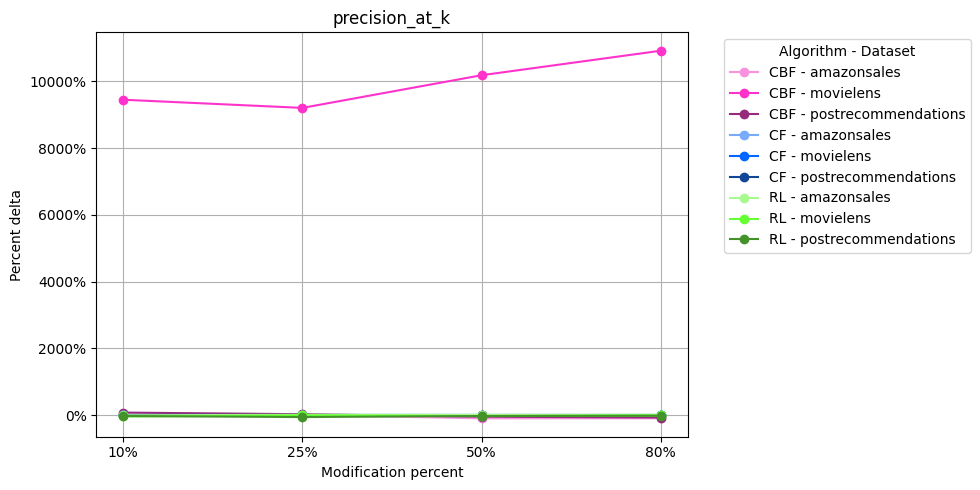

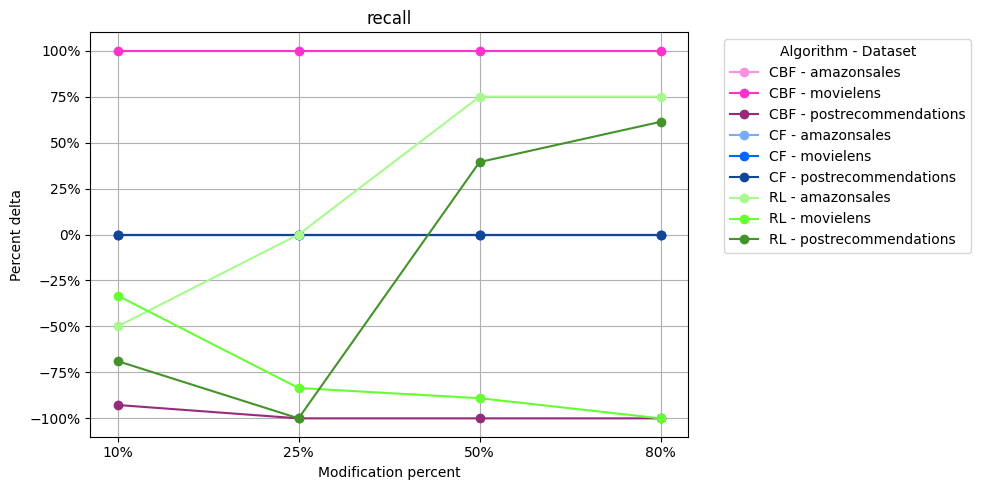

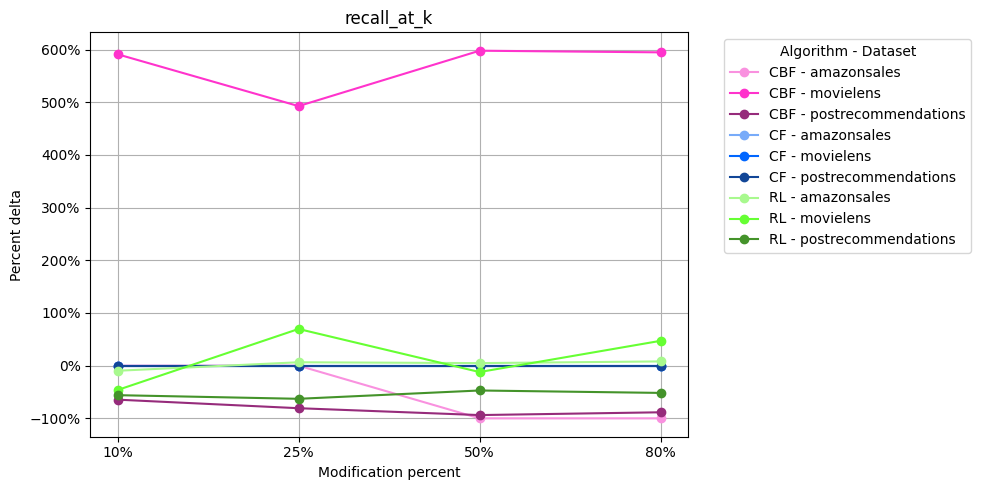

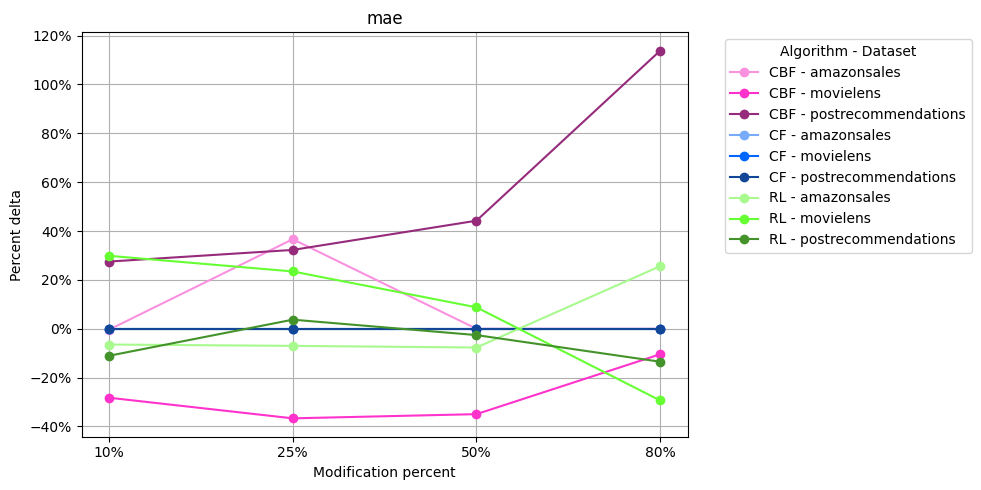

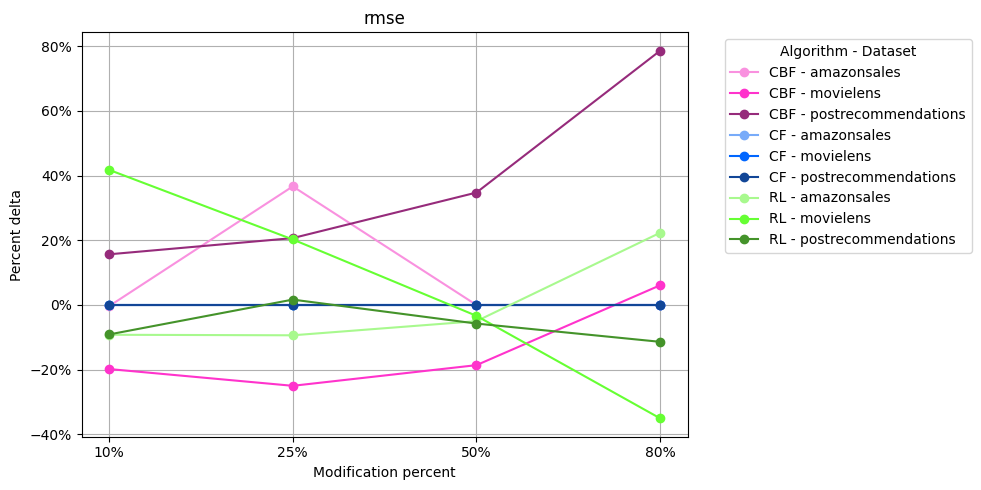

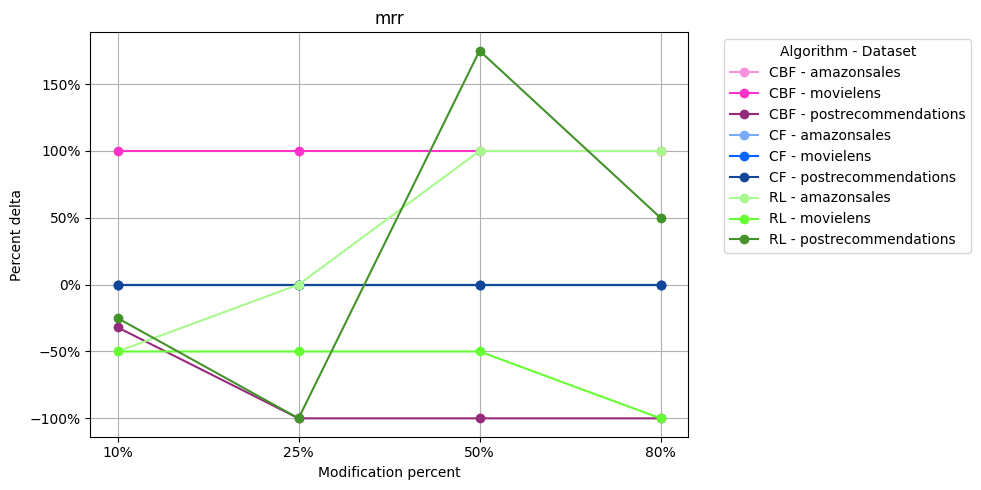

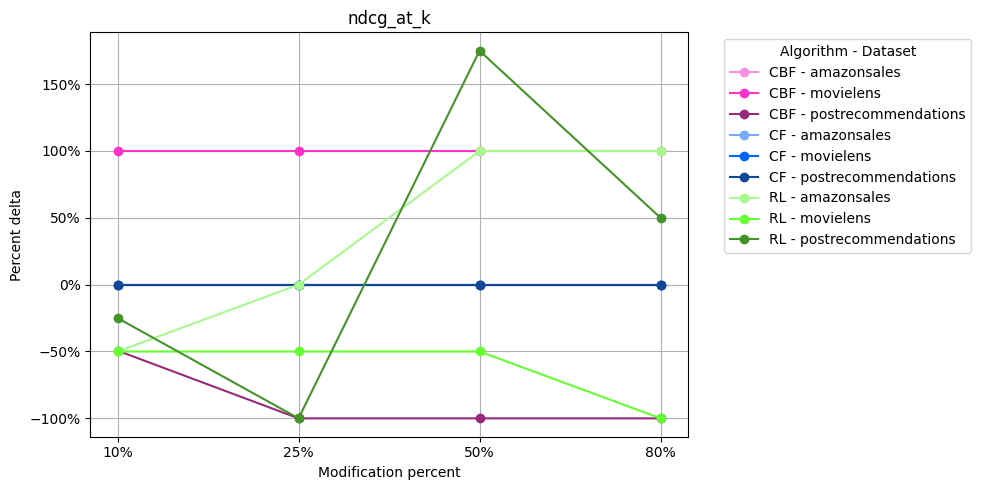

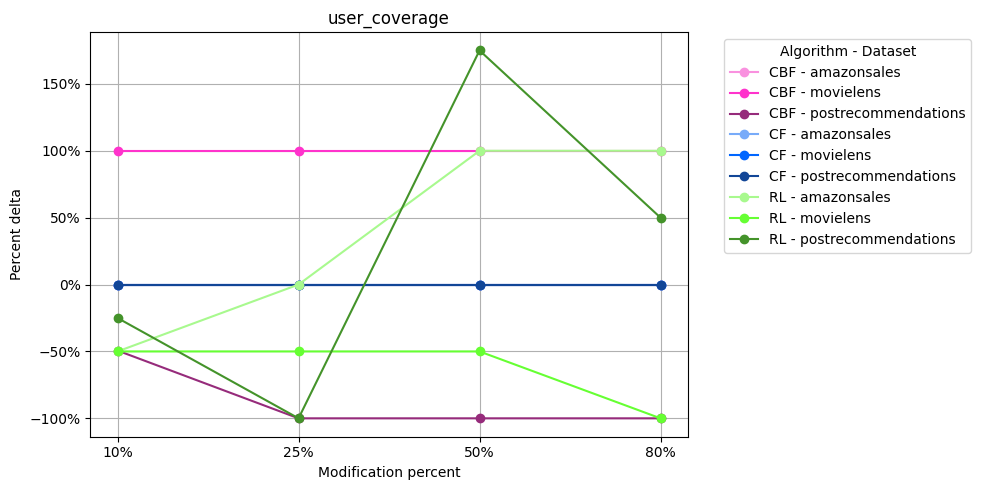

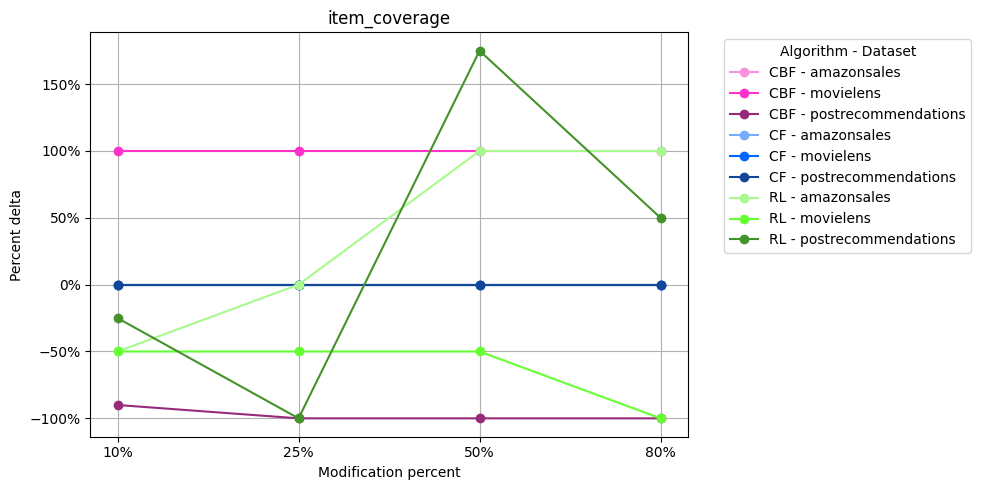

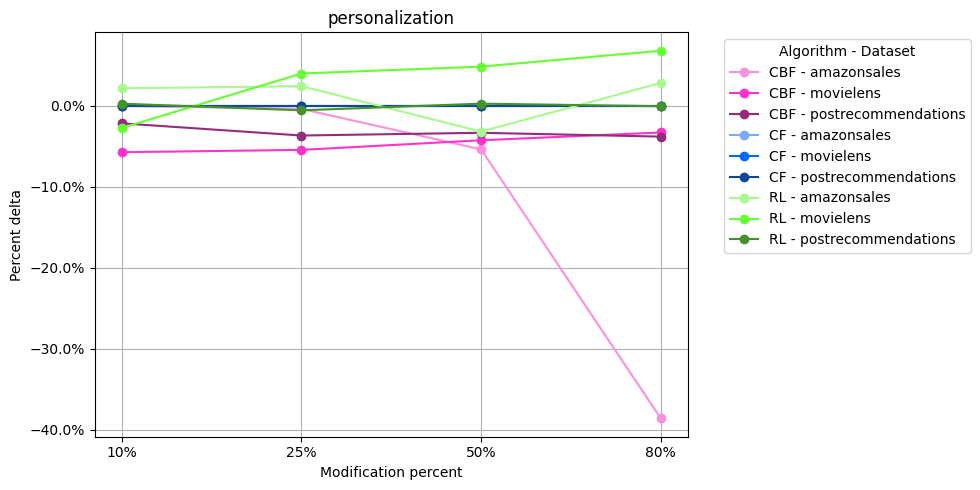

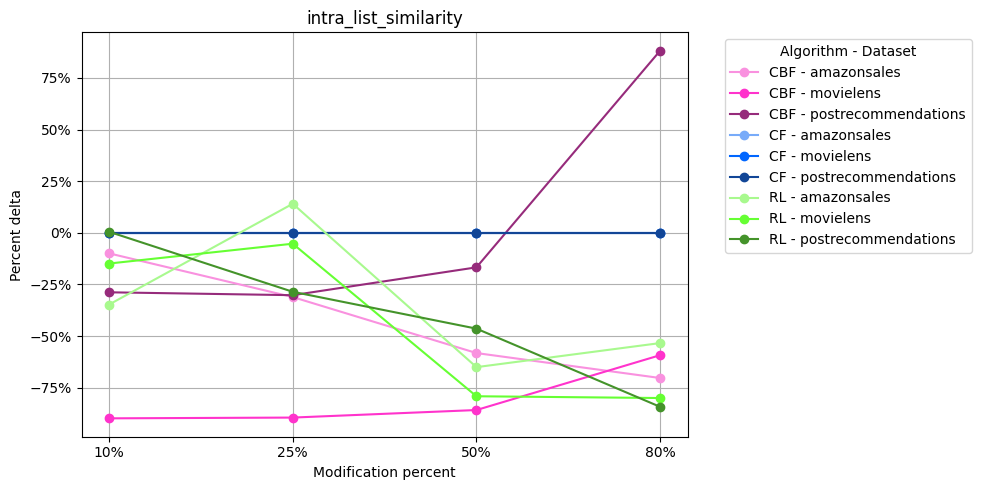

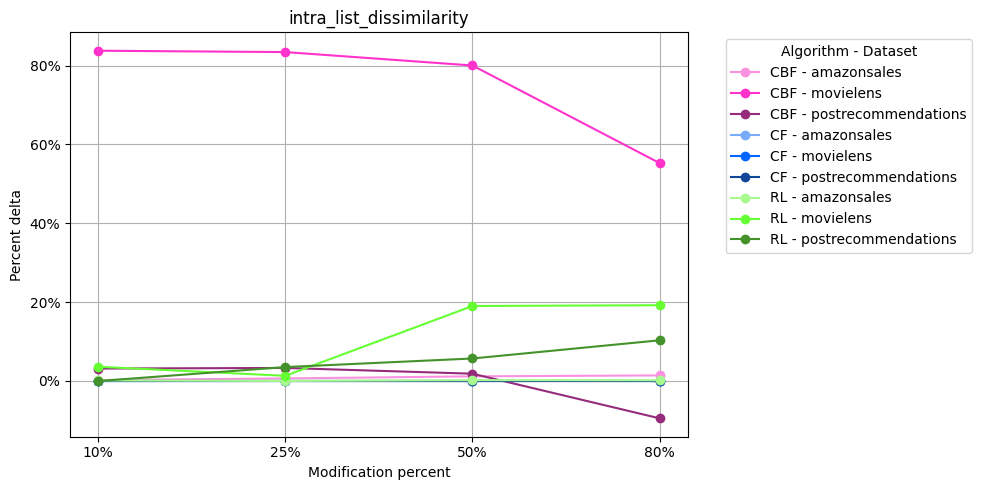

In [287]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

df = specific_df.copy()
df['combo'] = df['algorithm'] + ' - ' + df['dataset']

algorithms = df['algorithm'].unique()
base_colors = ['#ff33cc', '#0066ff', '#66ff33']
algorithm_colors = dict(zip(algorithms, base_colors))

for key in df['key'].unique():
    plt.figure(figsize=(10, 5))
    subset = df[df['key'] == key]

    for alg in algorithms:
        alg_subset = subset[subset['algorithm'] == alg]
        datasets = alg_subset['dataset'].unique()
        base_color = algorithm_colors[alg]

        for i, dataset in enumerate(datasets):
            line_data = alg_subset[alg_subset['dataset'] == dataset]
            label = f"{alg} - {dataset}"

            if i == 0:
                color = sns.light_palette(base_color, n_colors=3, input="rgb")[1]
            elif i == 1:
                color = base_color
            else:
                color = sns.dark_palette(base_color, n_colors=3, input="rgb")[1]

            plt.plot(
                line_data['percent'],
                line_data['percent_delta'],
                marker='o',
                label=label,
                color=color
            )

    plt.title(f"{key}")
    plt.xlabel("Modification percent")
    plt.ylabel("Percent delta")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.grid(True)
    plt.legend(title="Algorithm - Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


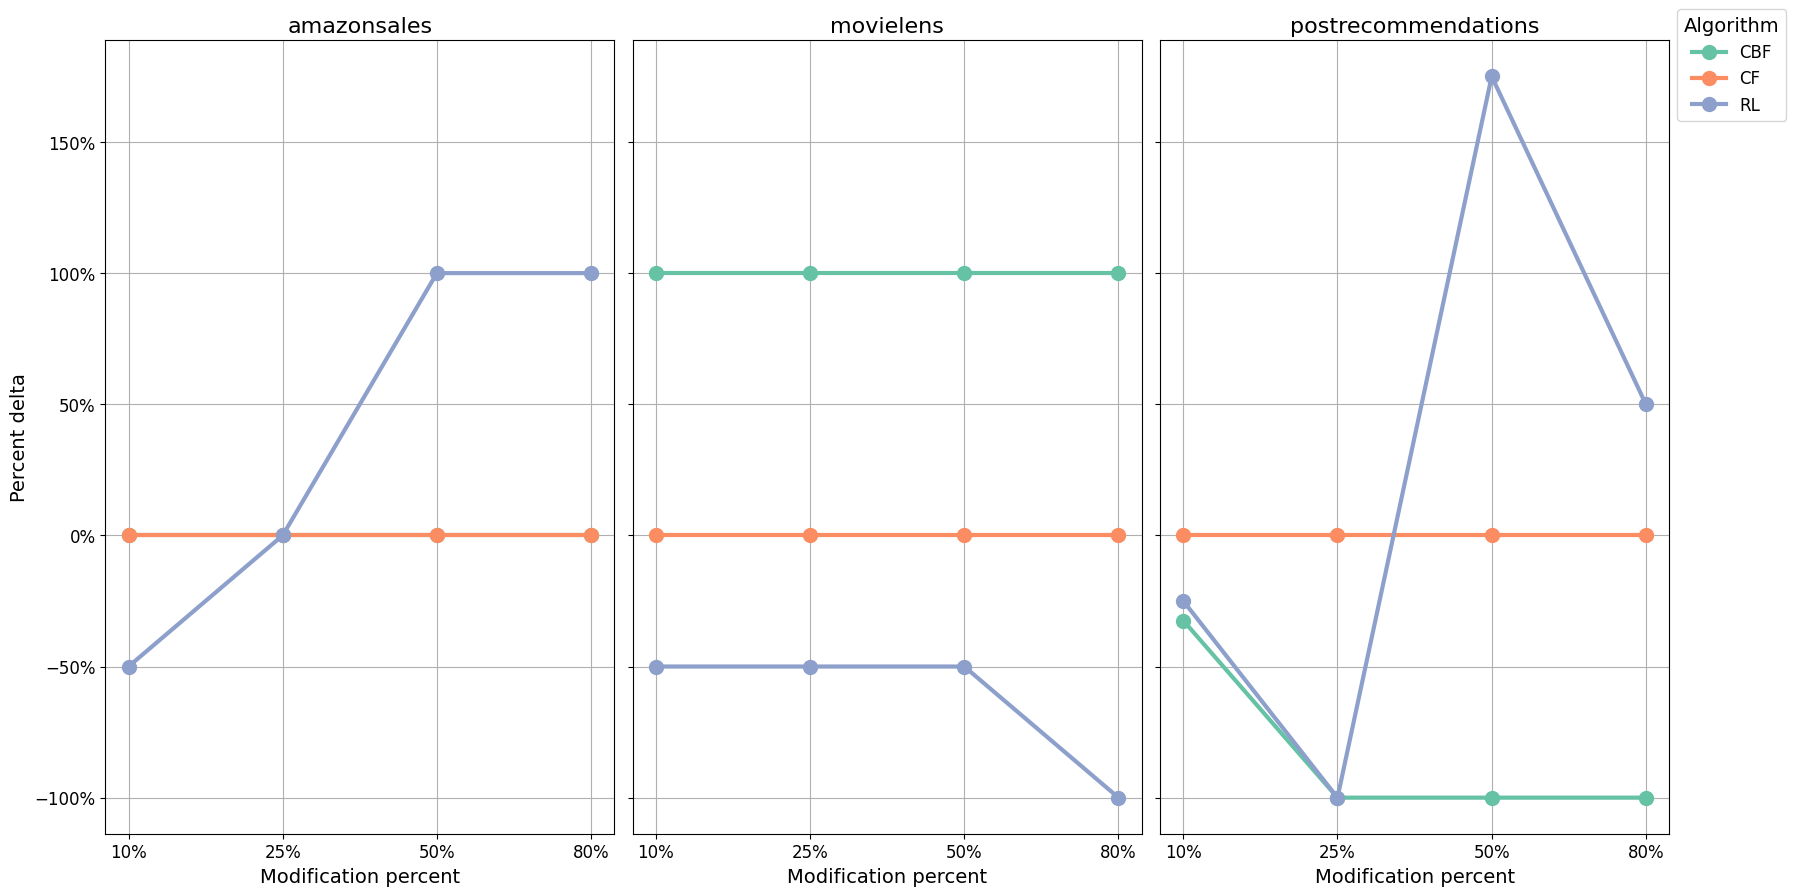

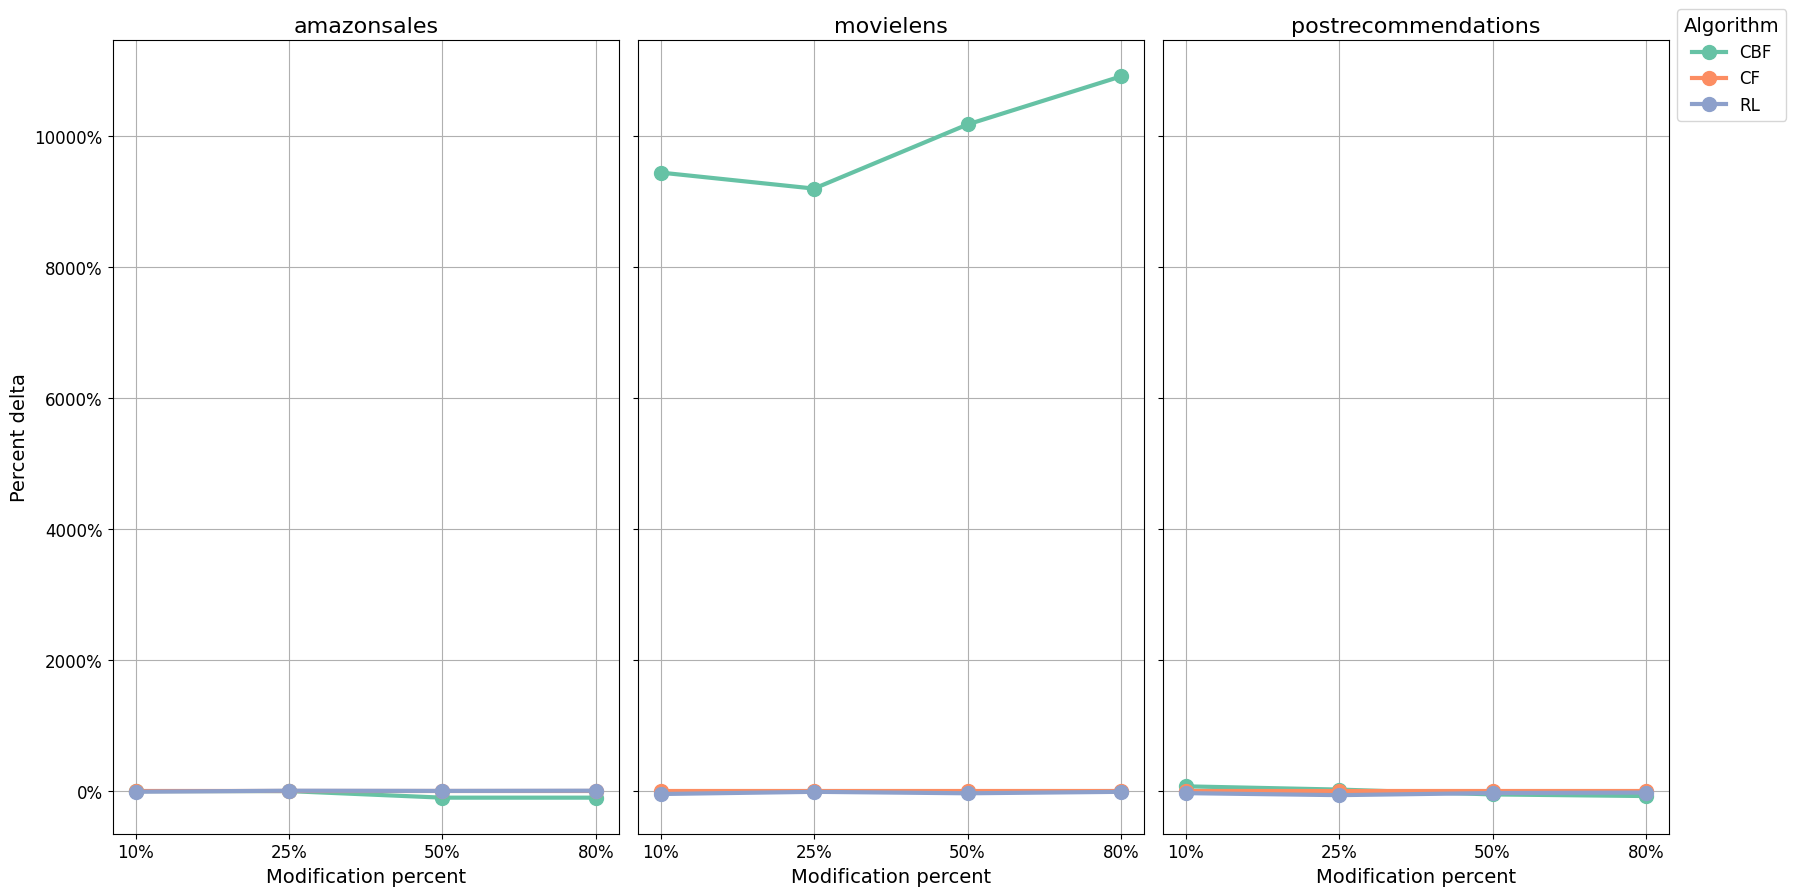

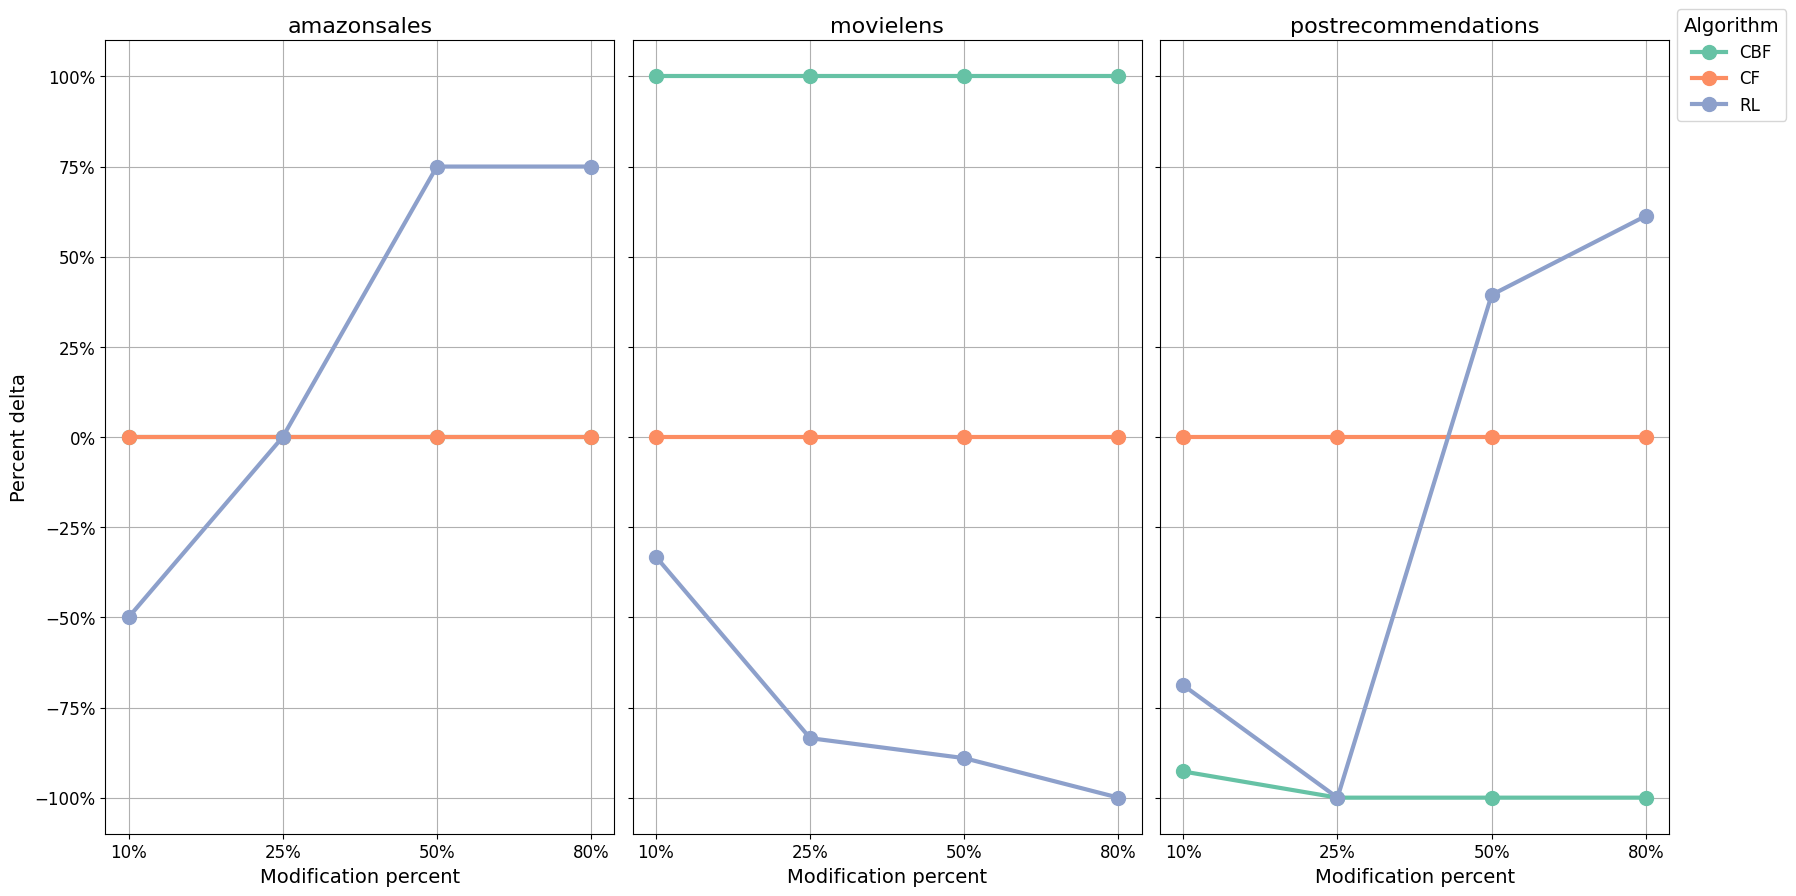

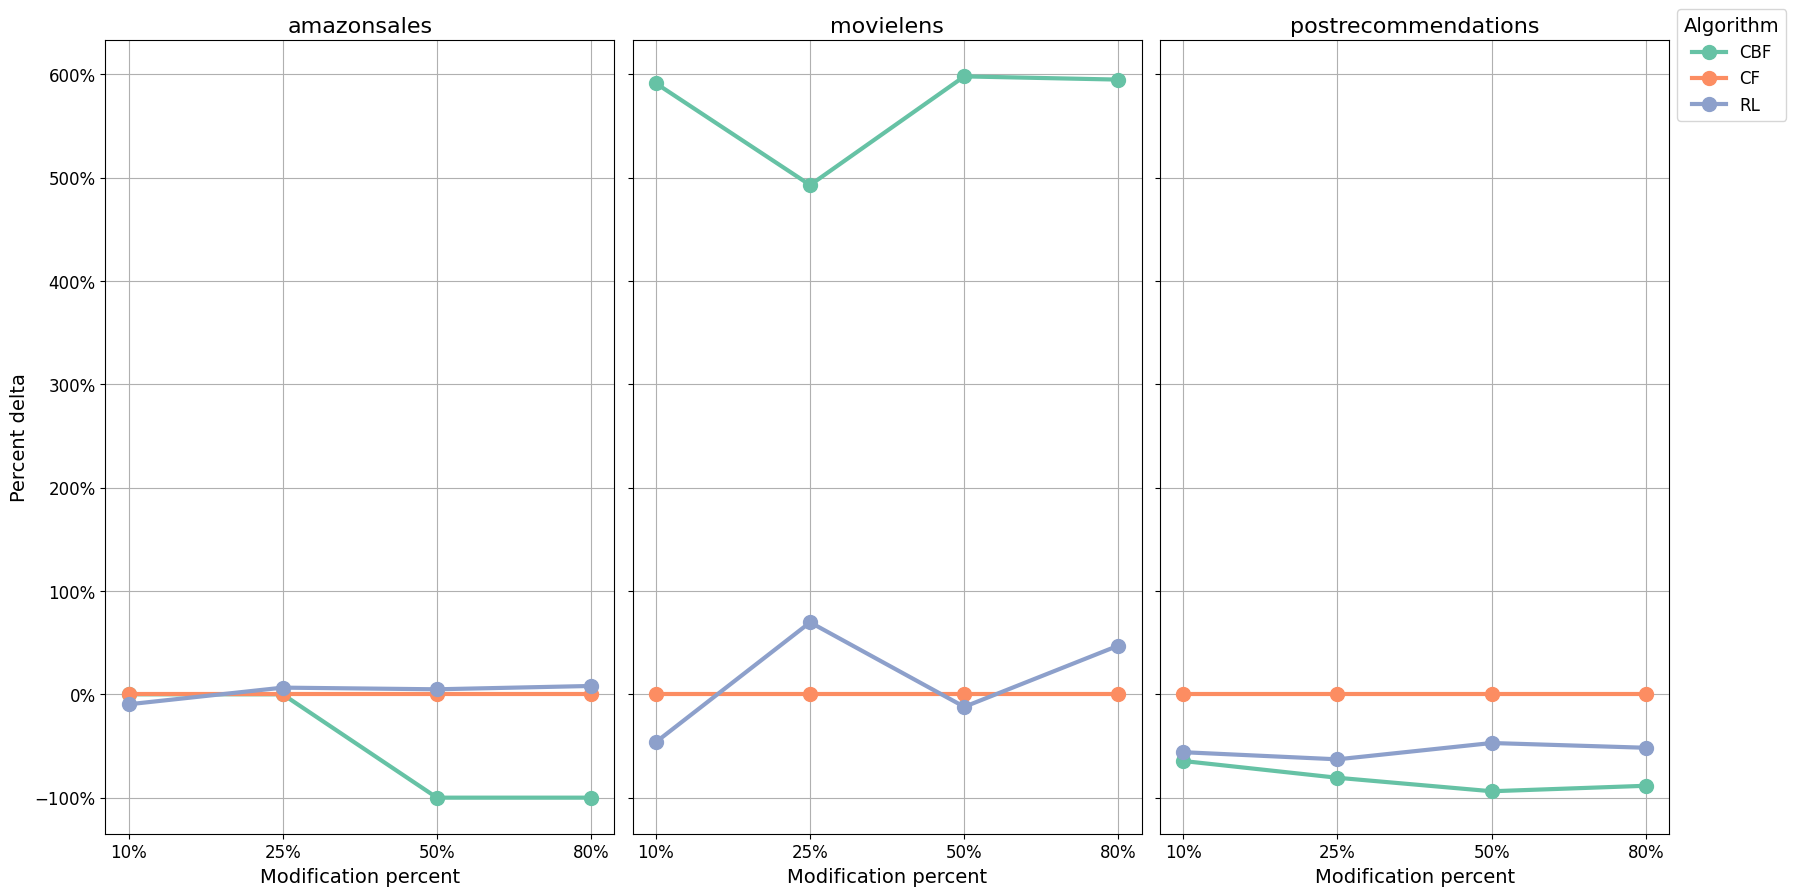

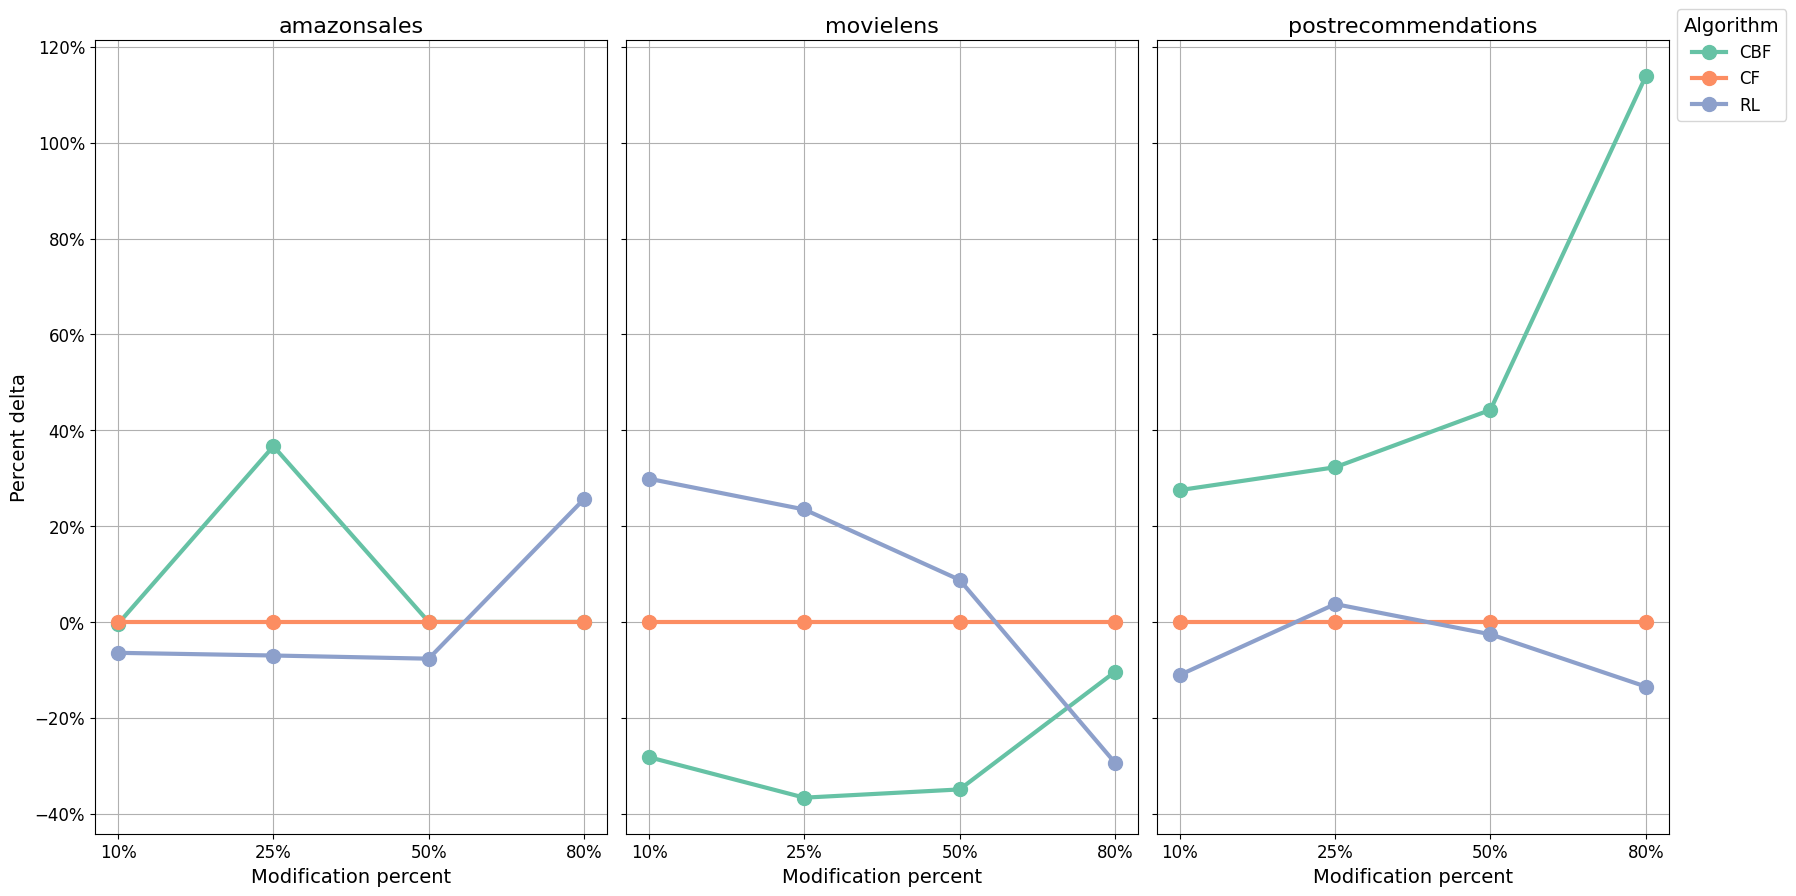

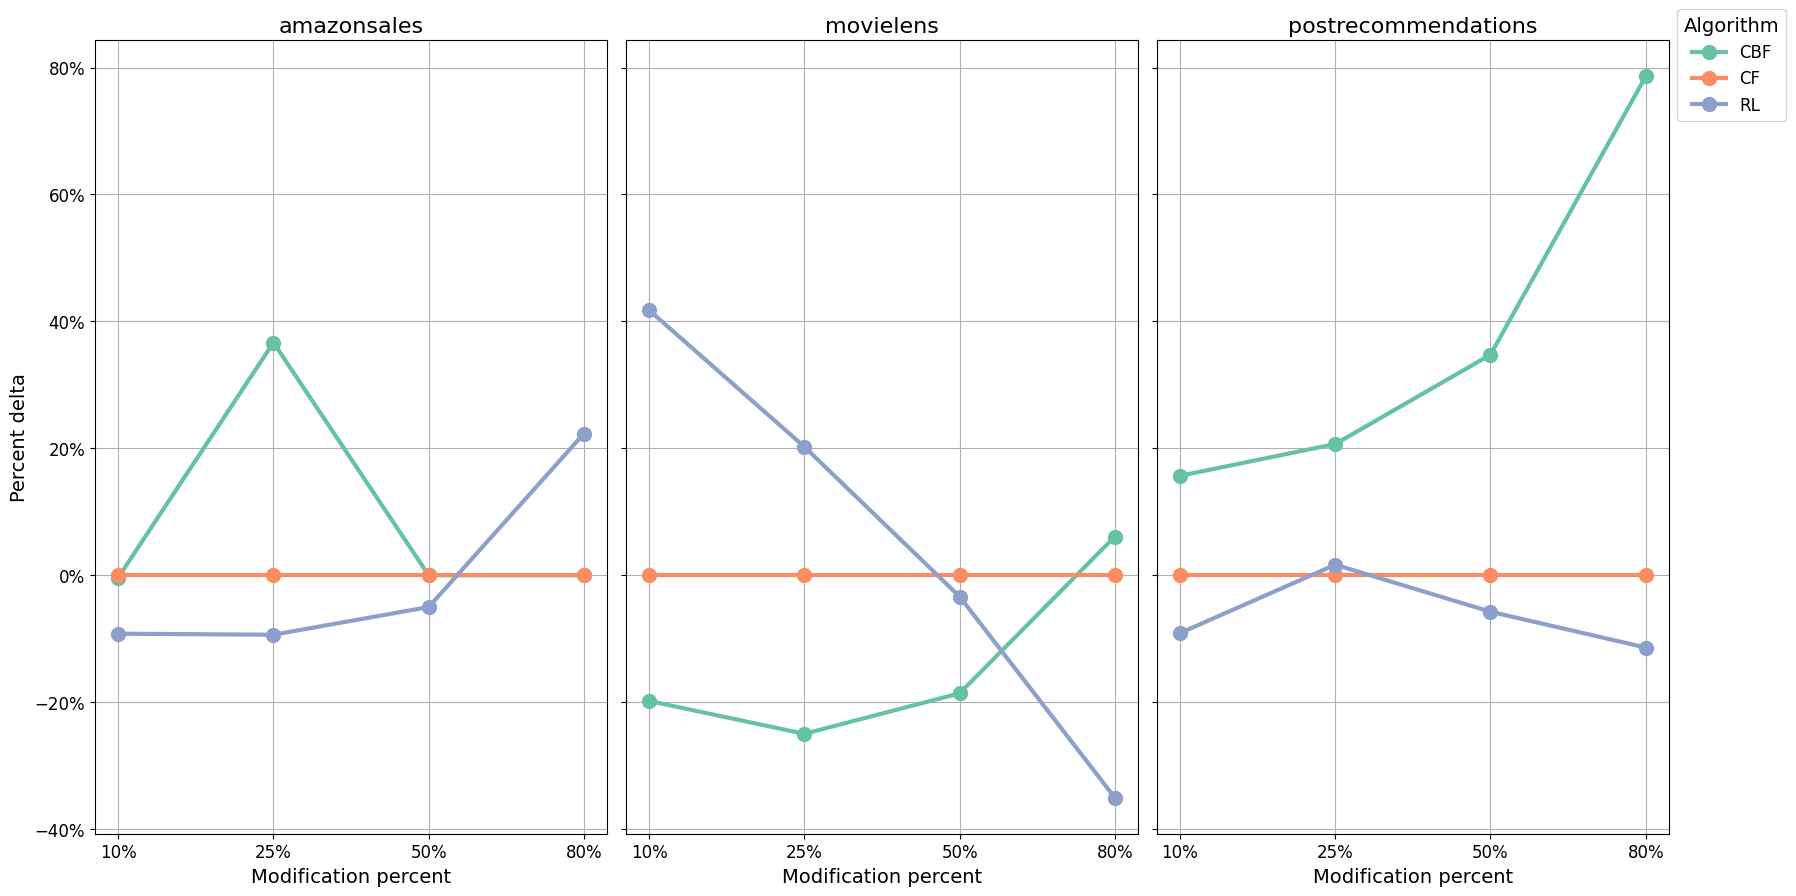

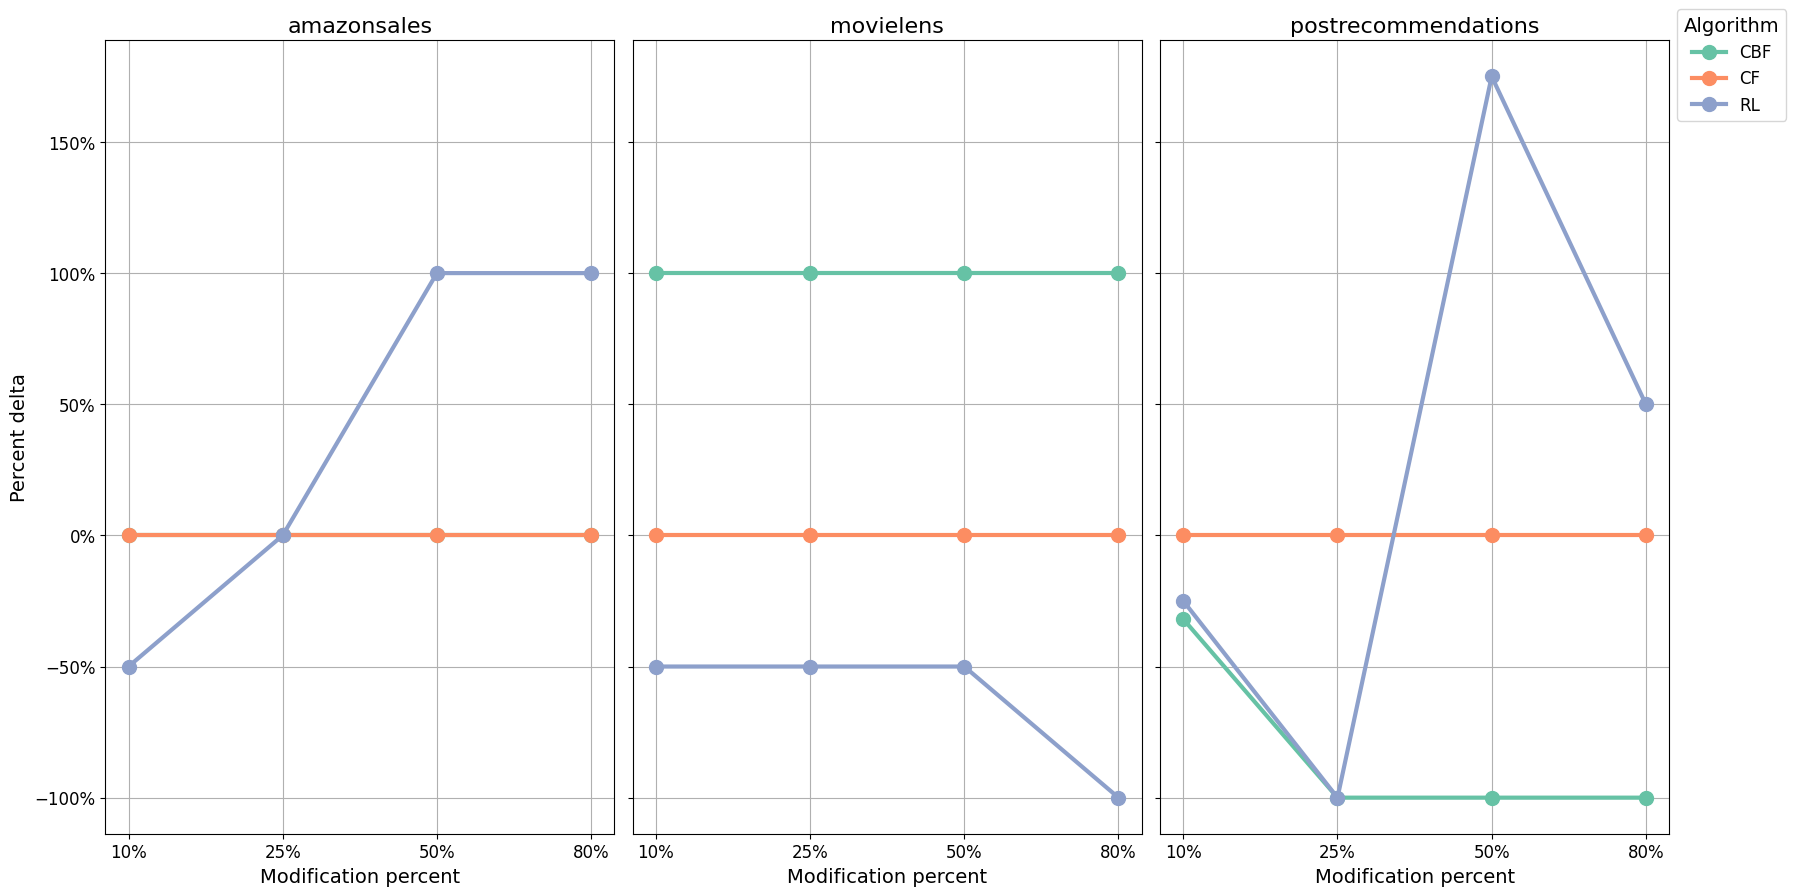

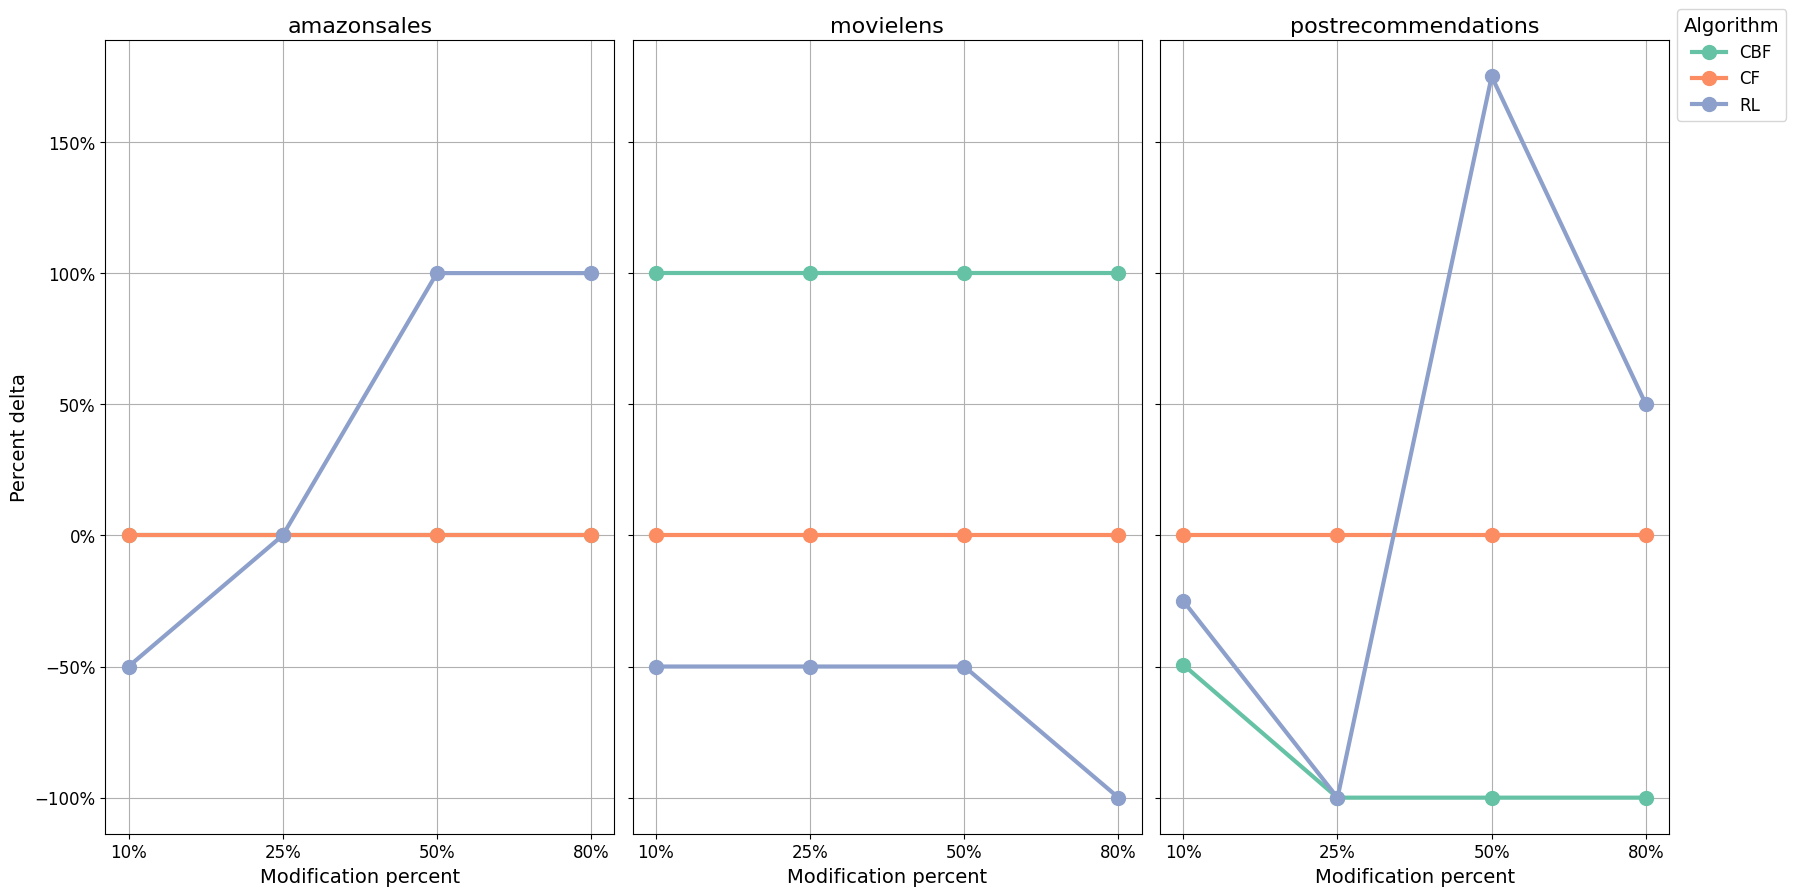

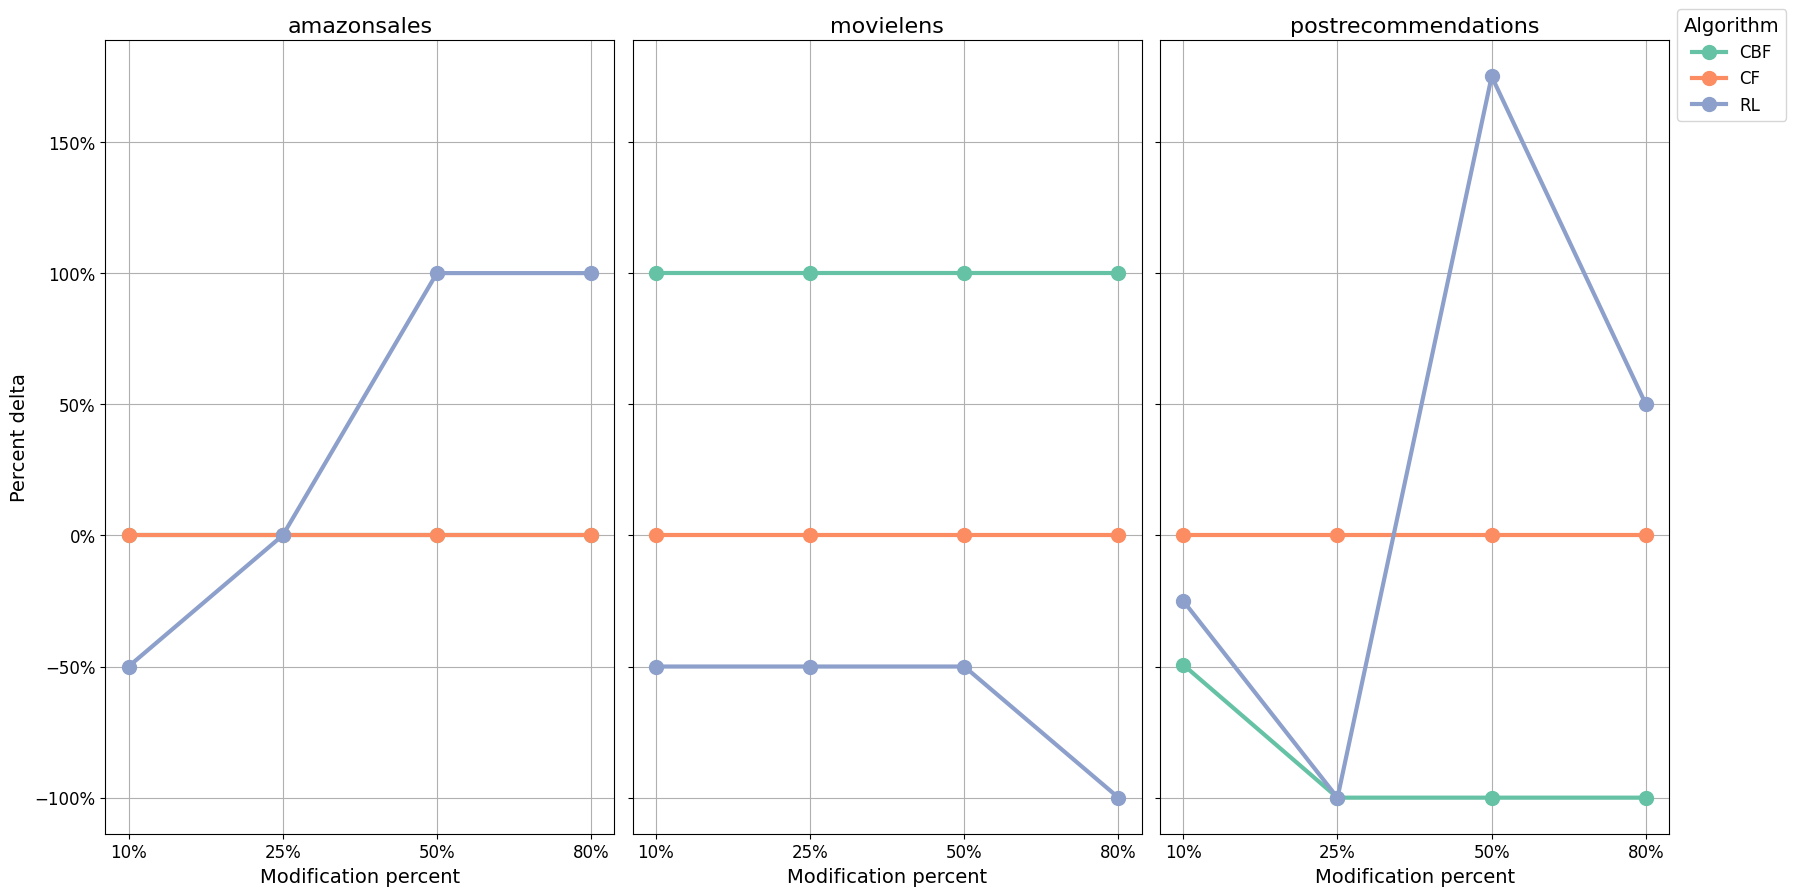

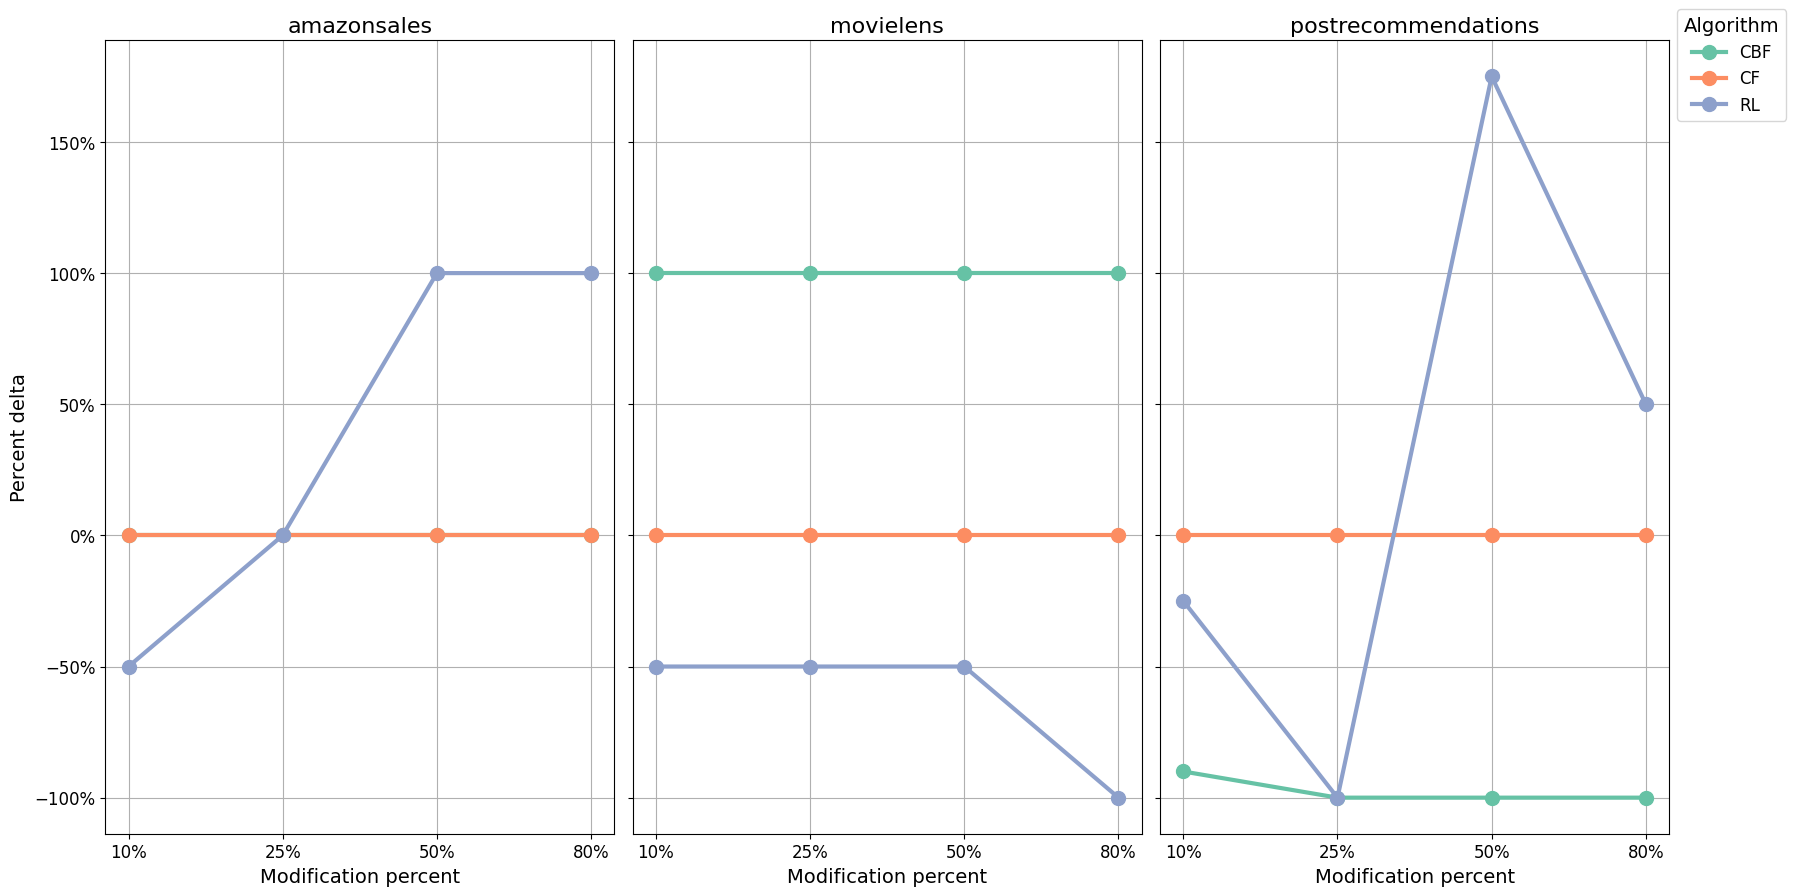

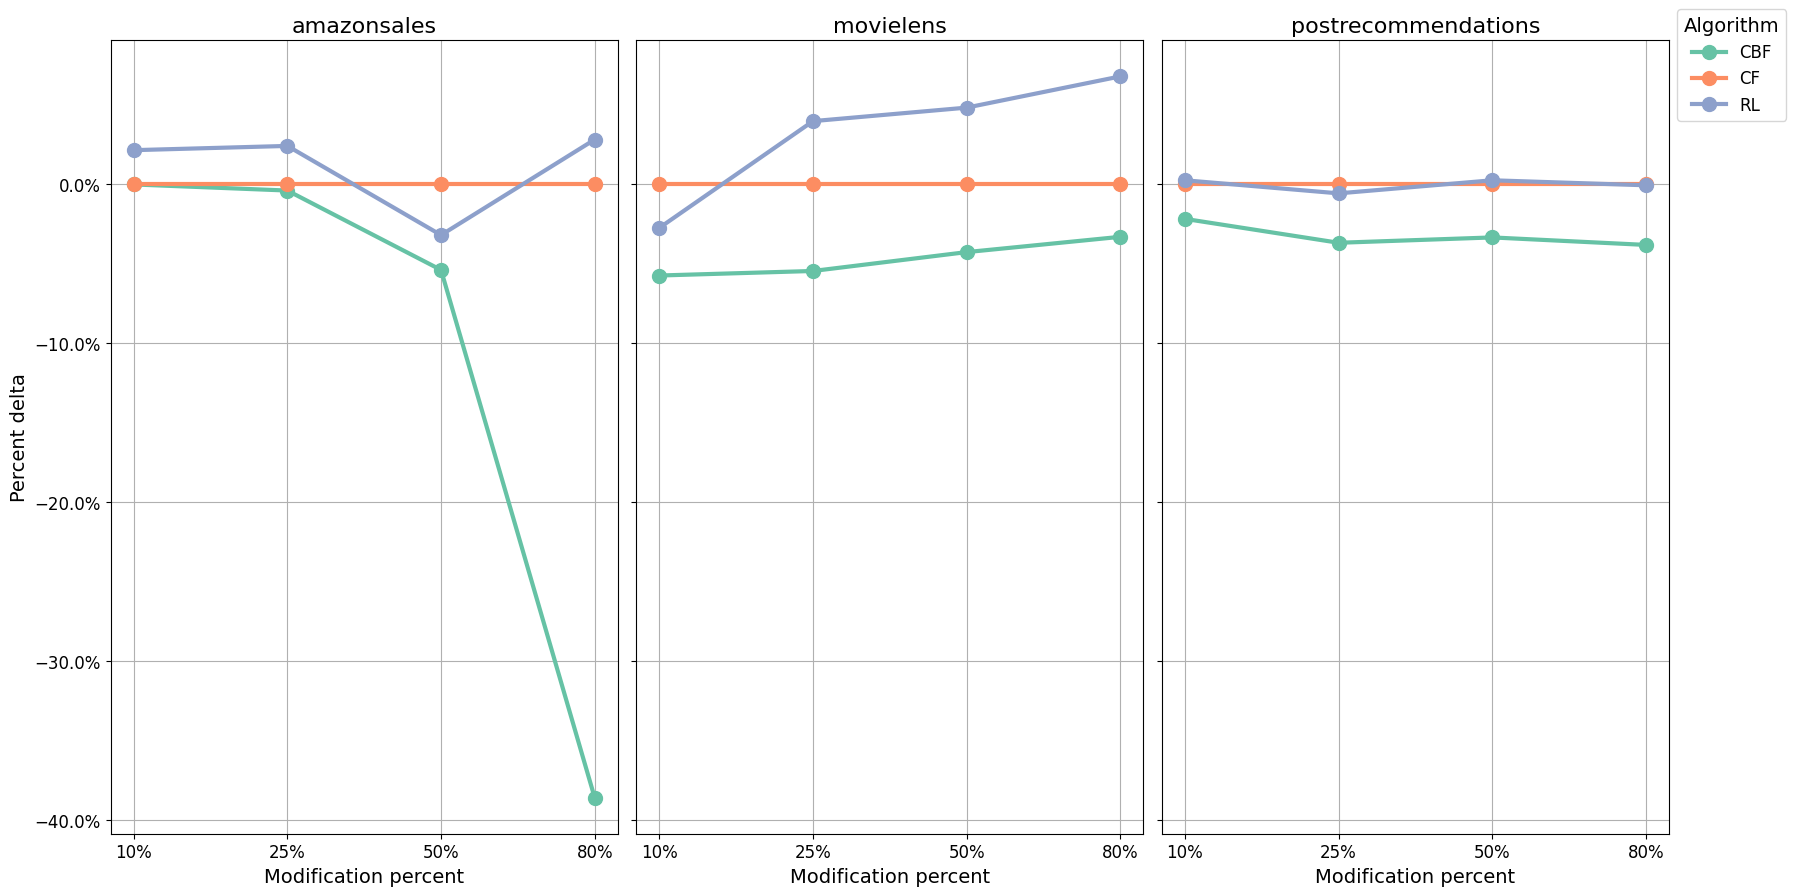

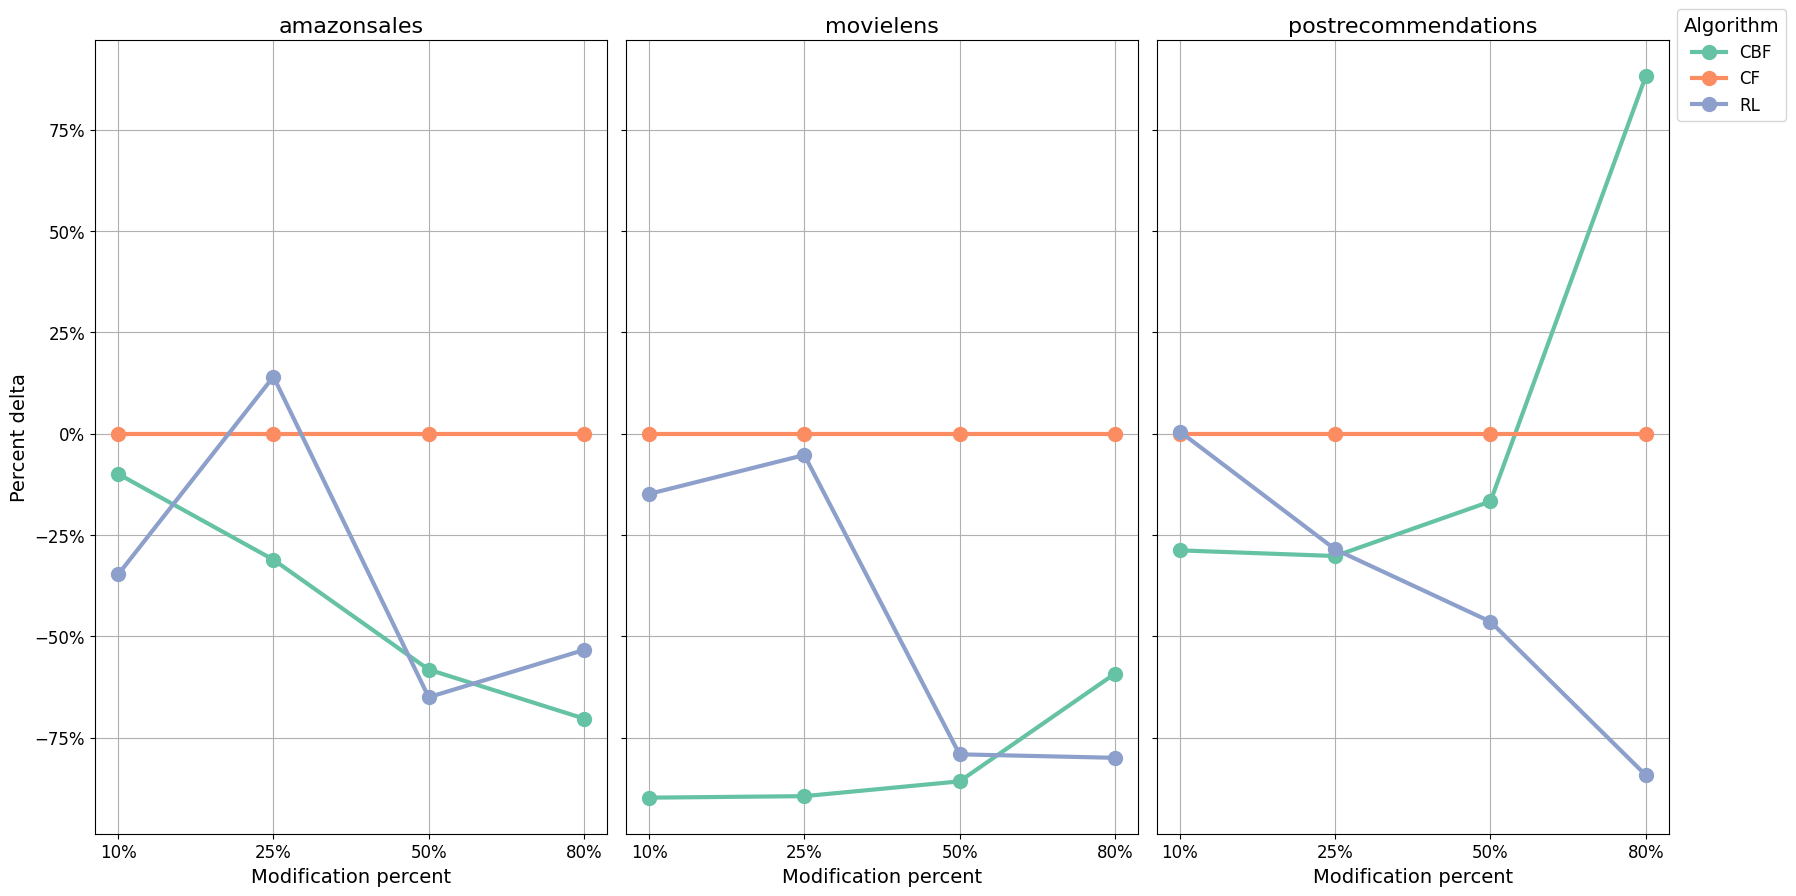

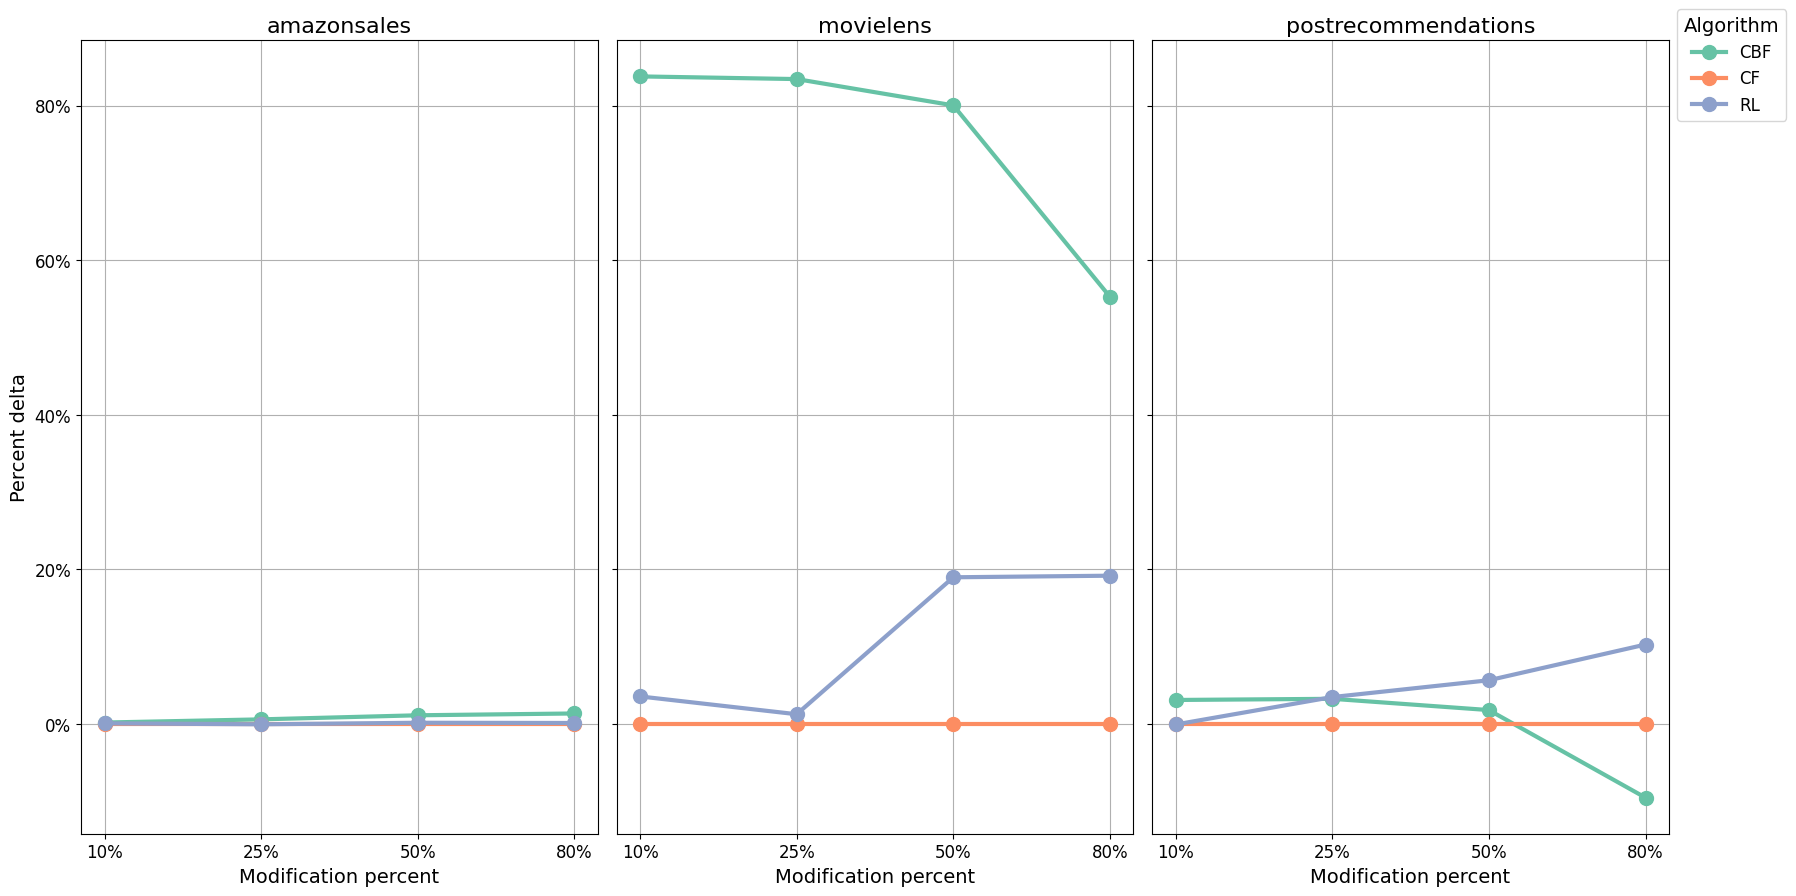

In [308]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

df = specific_df.copy()
df['combo'] = df['algorithm'] + ' - ' + df['dataset']

algorithms = df['algorithm'].unique()
datasets = df['dataset'].unique()

# Paleta Set2 z Seaborn — kolory do legendy
palette = sns.color_palette("Set2", n_colors=len(algorithms))
algorithm_colors = dict(zip(algorithms, palette))

for key in df['key'].unique():
    key_subset = df[df['key'] == key]

    fig, axes = plt.subplots(1, 3, figsize=(18, 9), sharey=True)
    
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        dataset_subset = key_subset[key_subset['dataset'] == dataset]

        for alg in algorithms:
            alg_subset = dataset_subset[dataset_subset['algorithm'] == alg]
            base_color = algorithm_colors[alg]

            ax.plot(
                alg_subset['percent'],
                alg_subset['percent_delta'],
                marker='o',
                label=alg,
                color=base_color,
                linewidth=3,    # pogrubienie linii
                markersize=10   # powiększenie kropek
            )

        ax.set_title(f"{dataset}", fontsize=16)
        ax.set_xlabel("Modification percent", fontsize=14)
        ax.tick_params(axis='both', labelsize=12)
        ax.grid(True)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        if i == 0:
            ax.set_ylabel("Percent delta", fontsize=14)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Algorithm",
        title_fontsize=14,
        fontsize=12,
        bbox_to_anchor=(0.93, 1),
        loc='upper left'
    )

    plt.tight_layout()
    plt.subplots_adjust(right=0.93)
    plt.show()


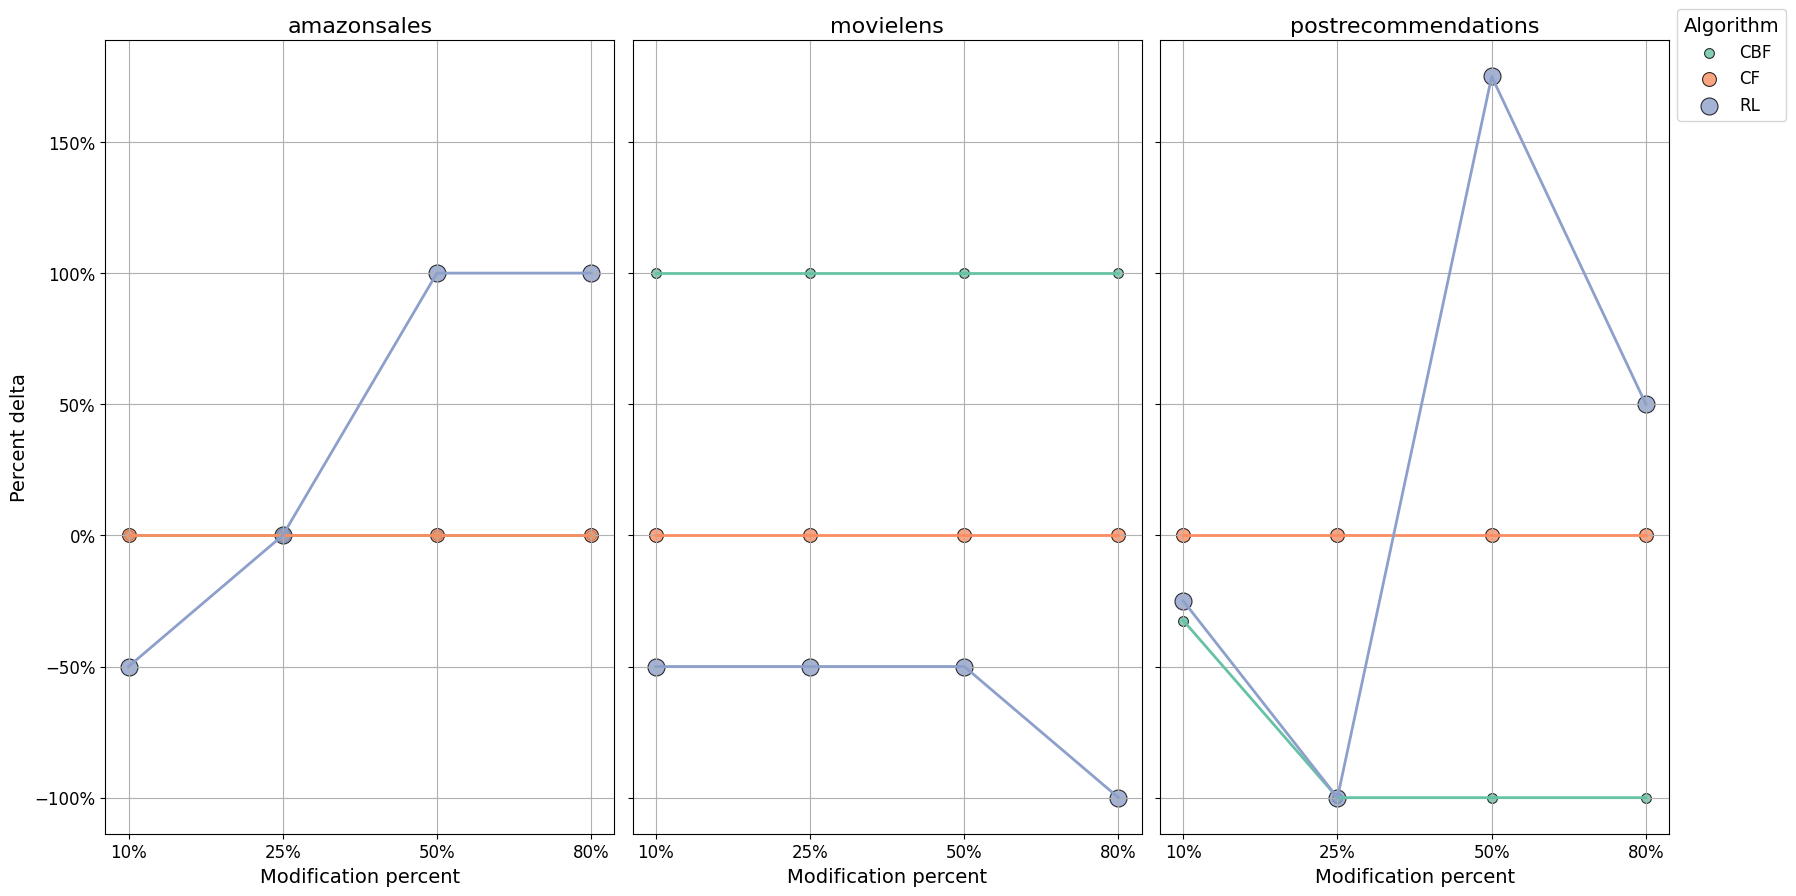

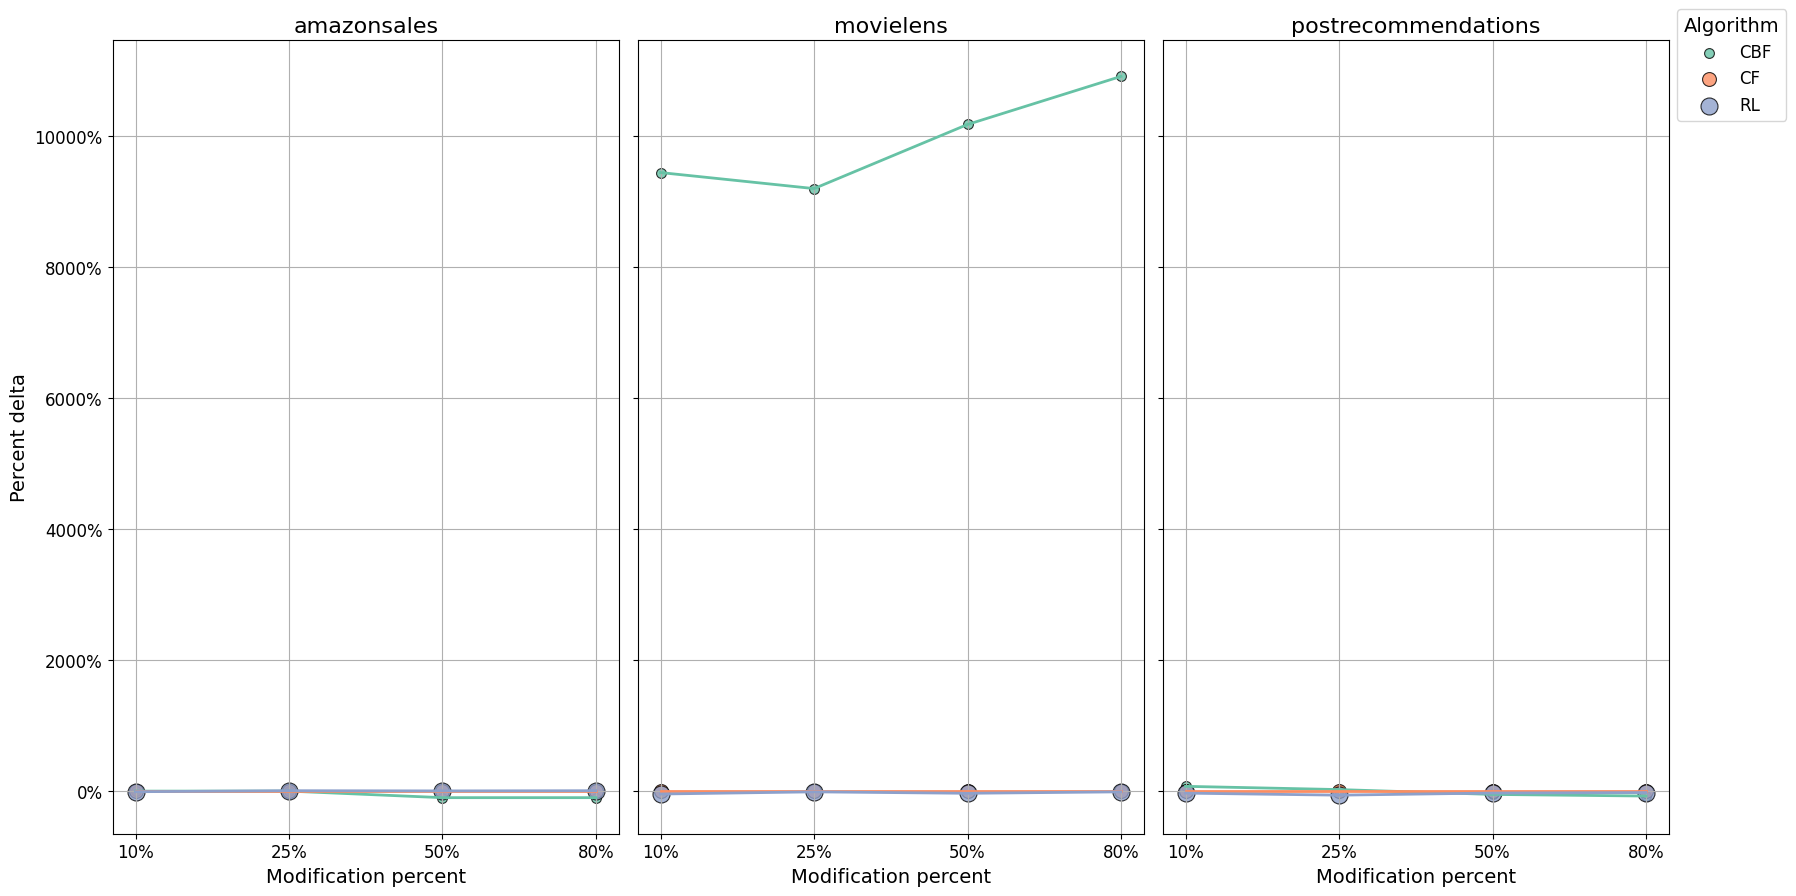

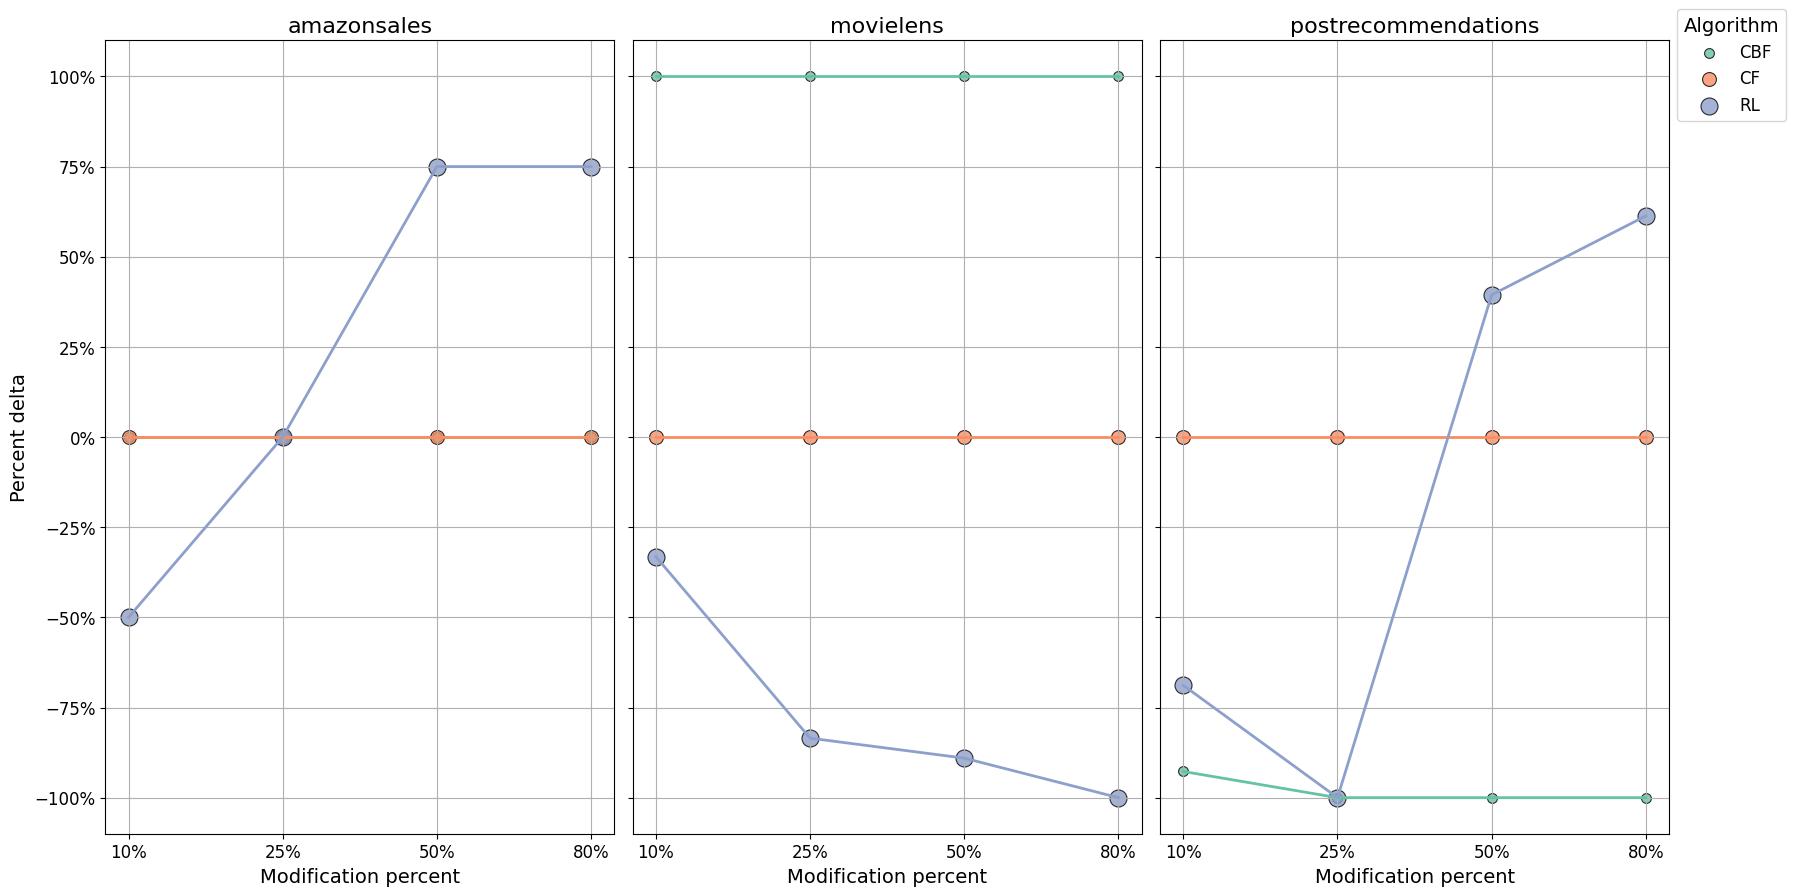

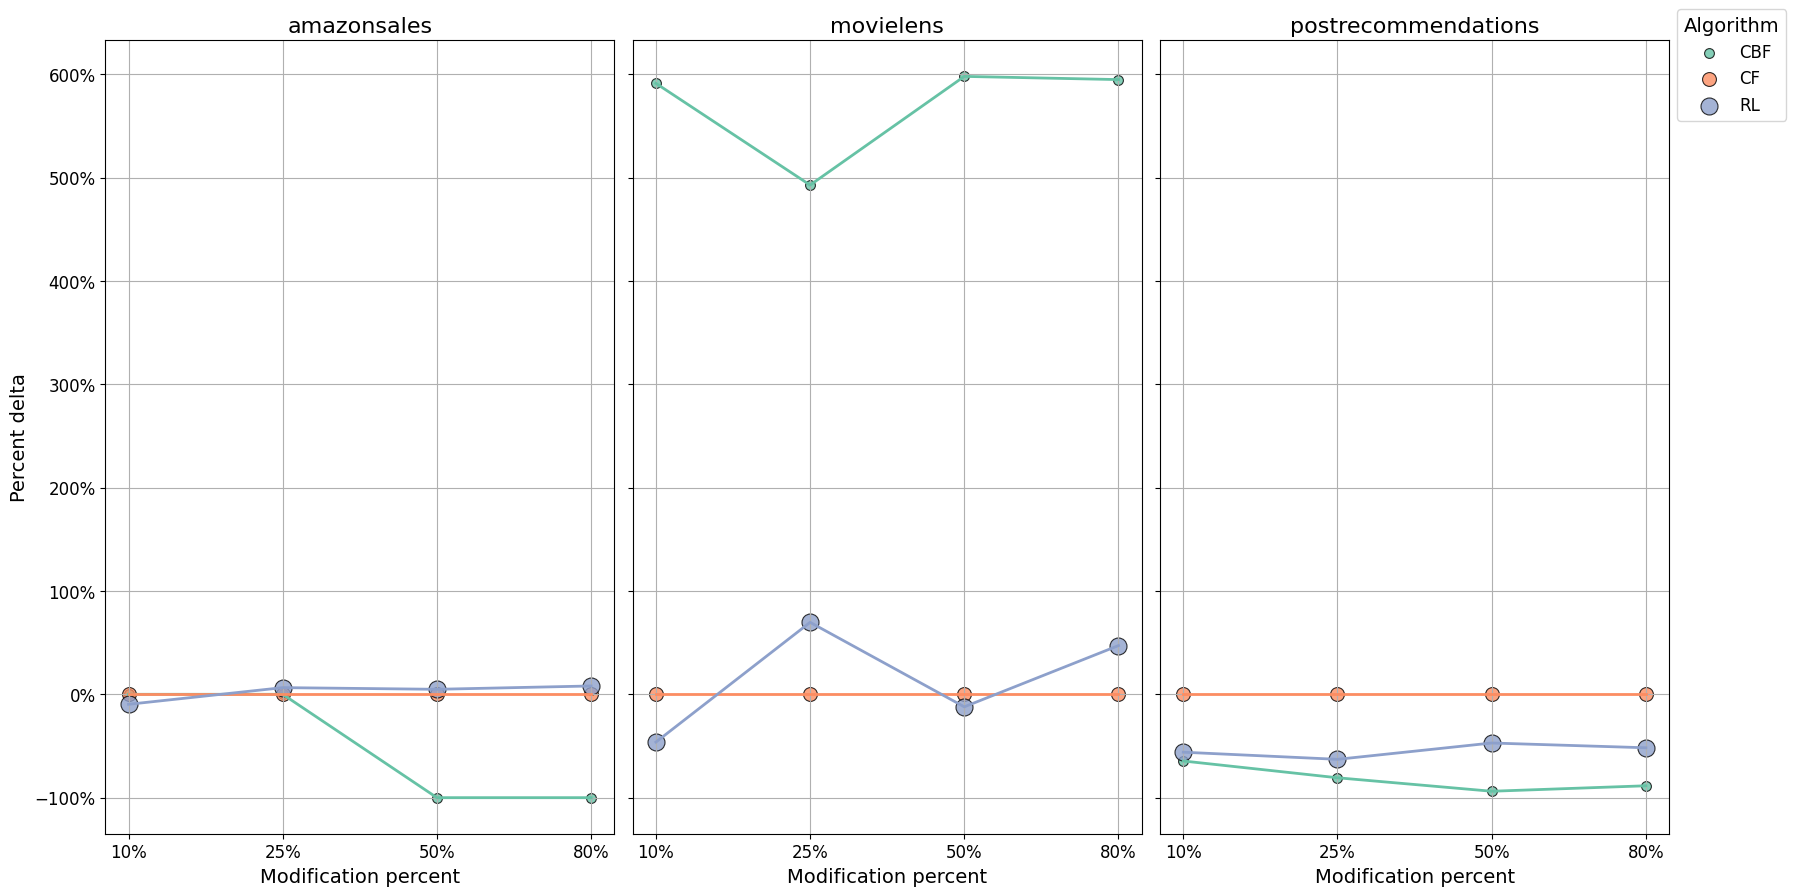

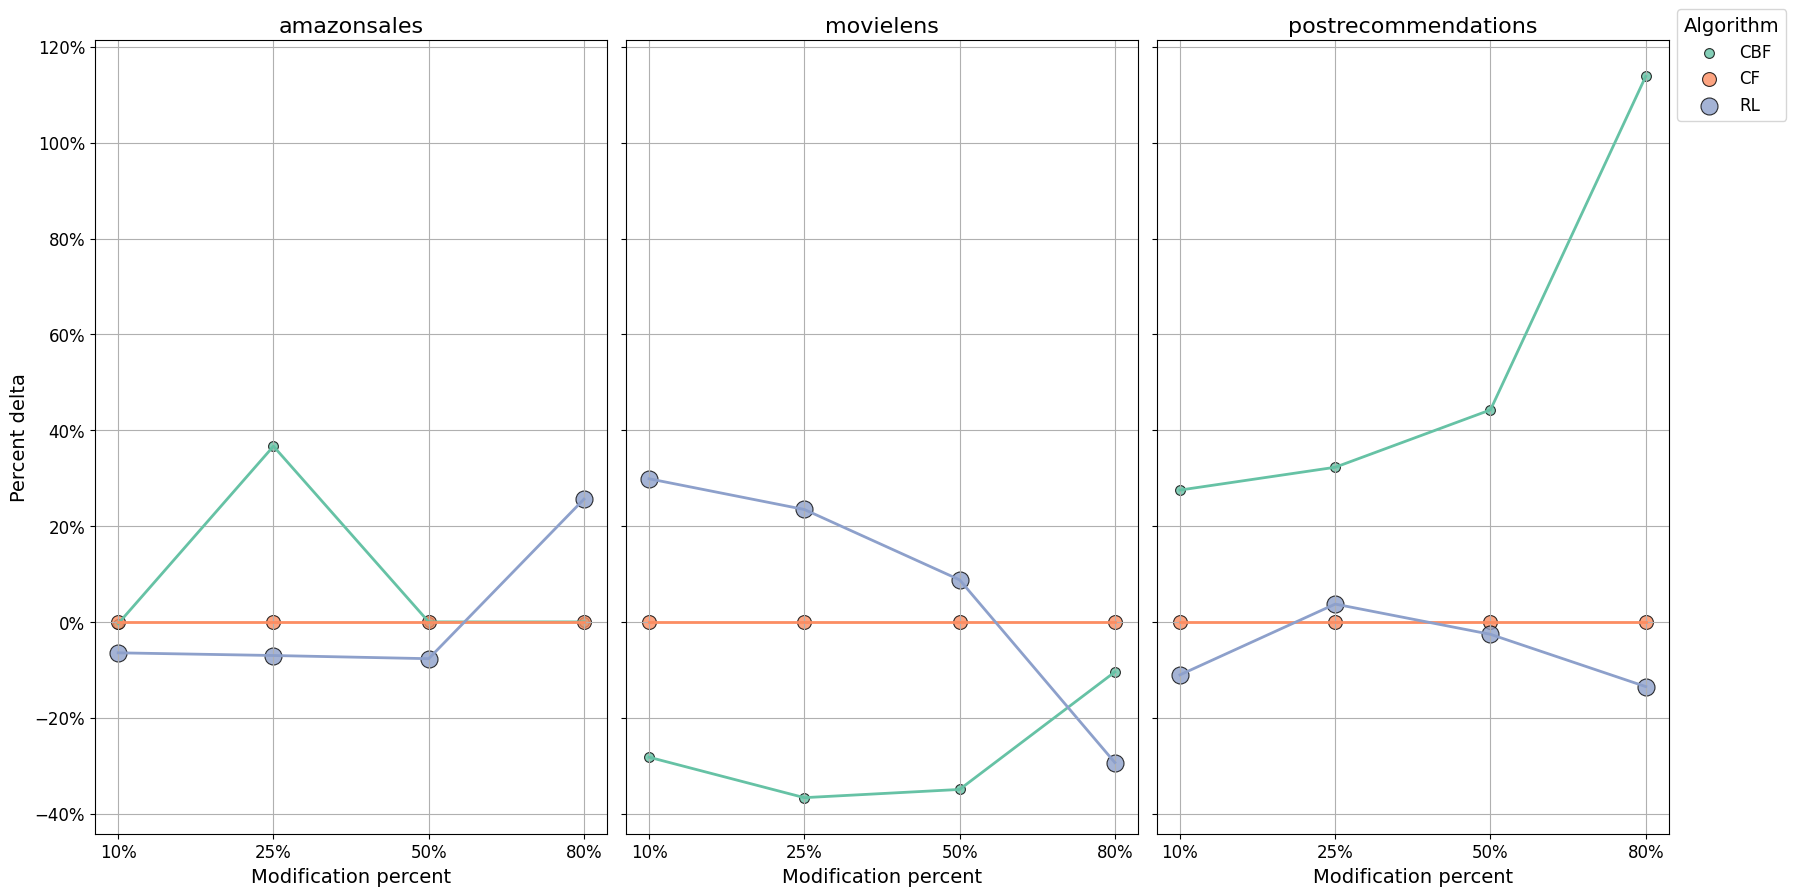

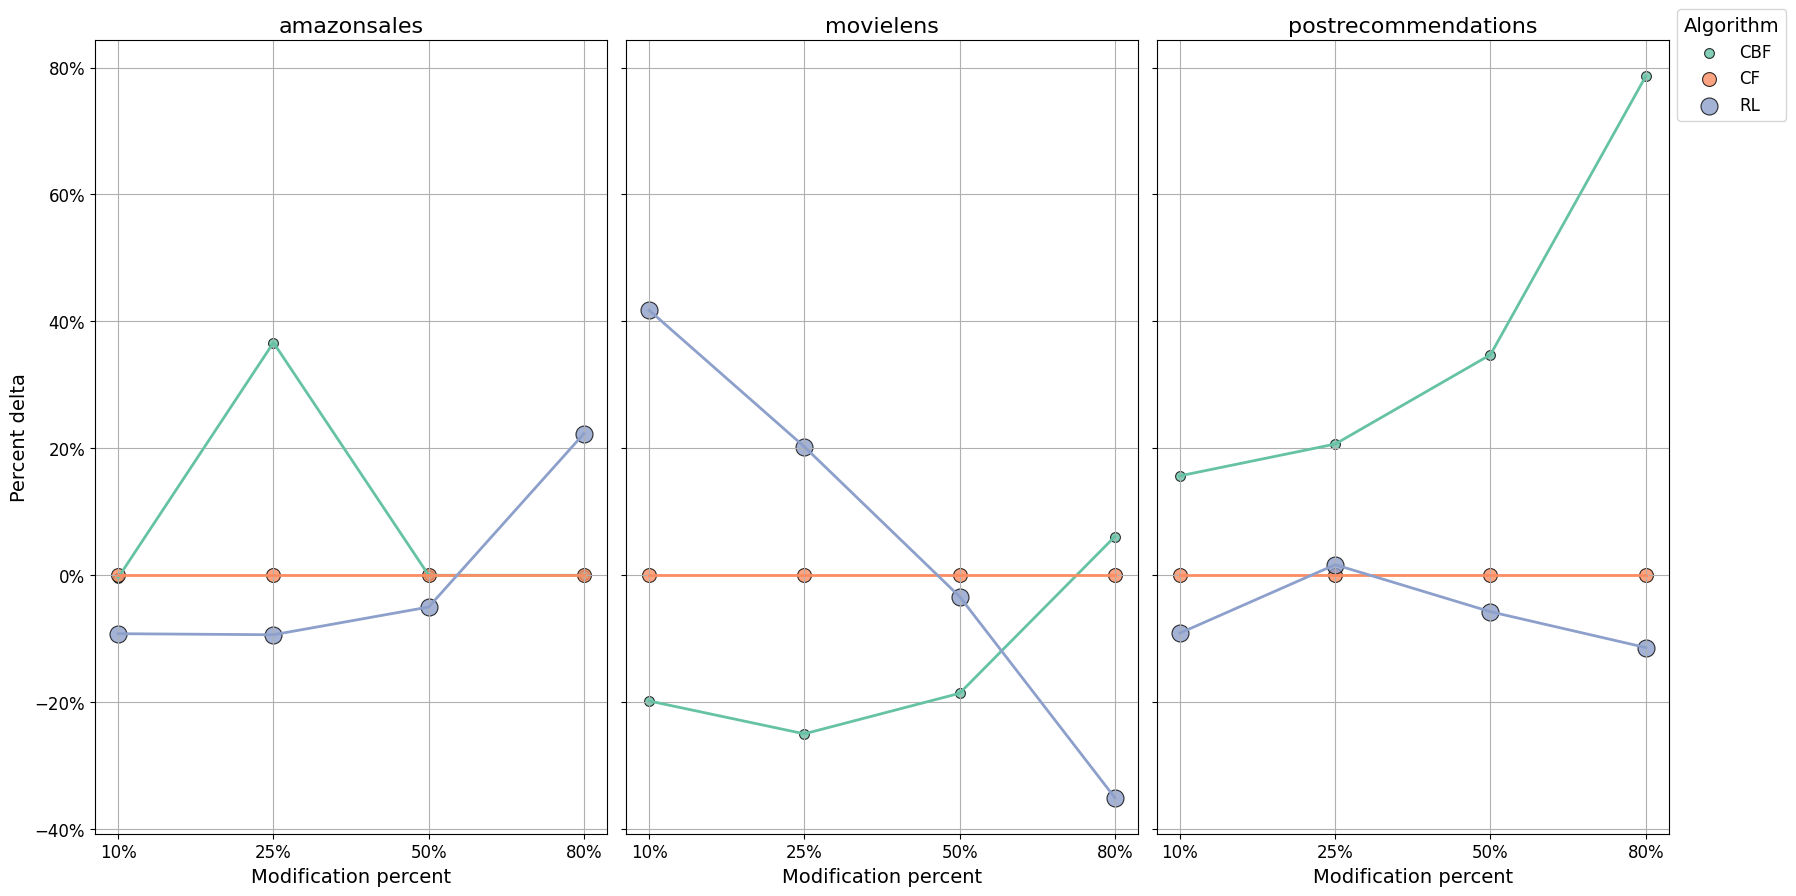

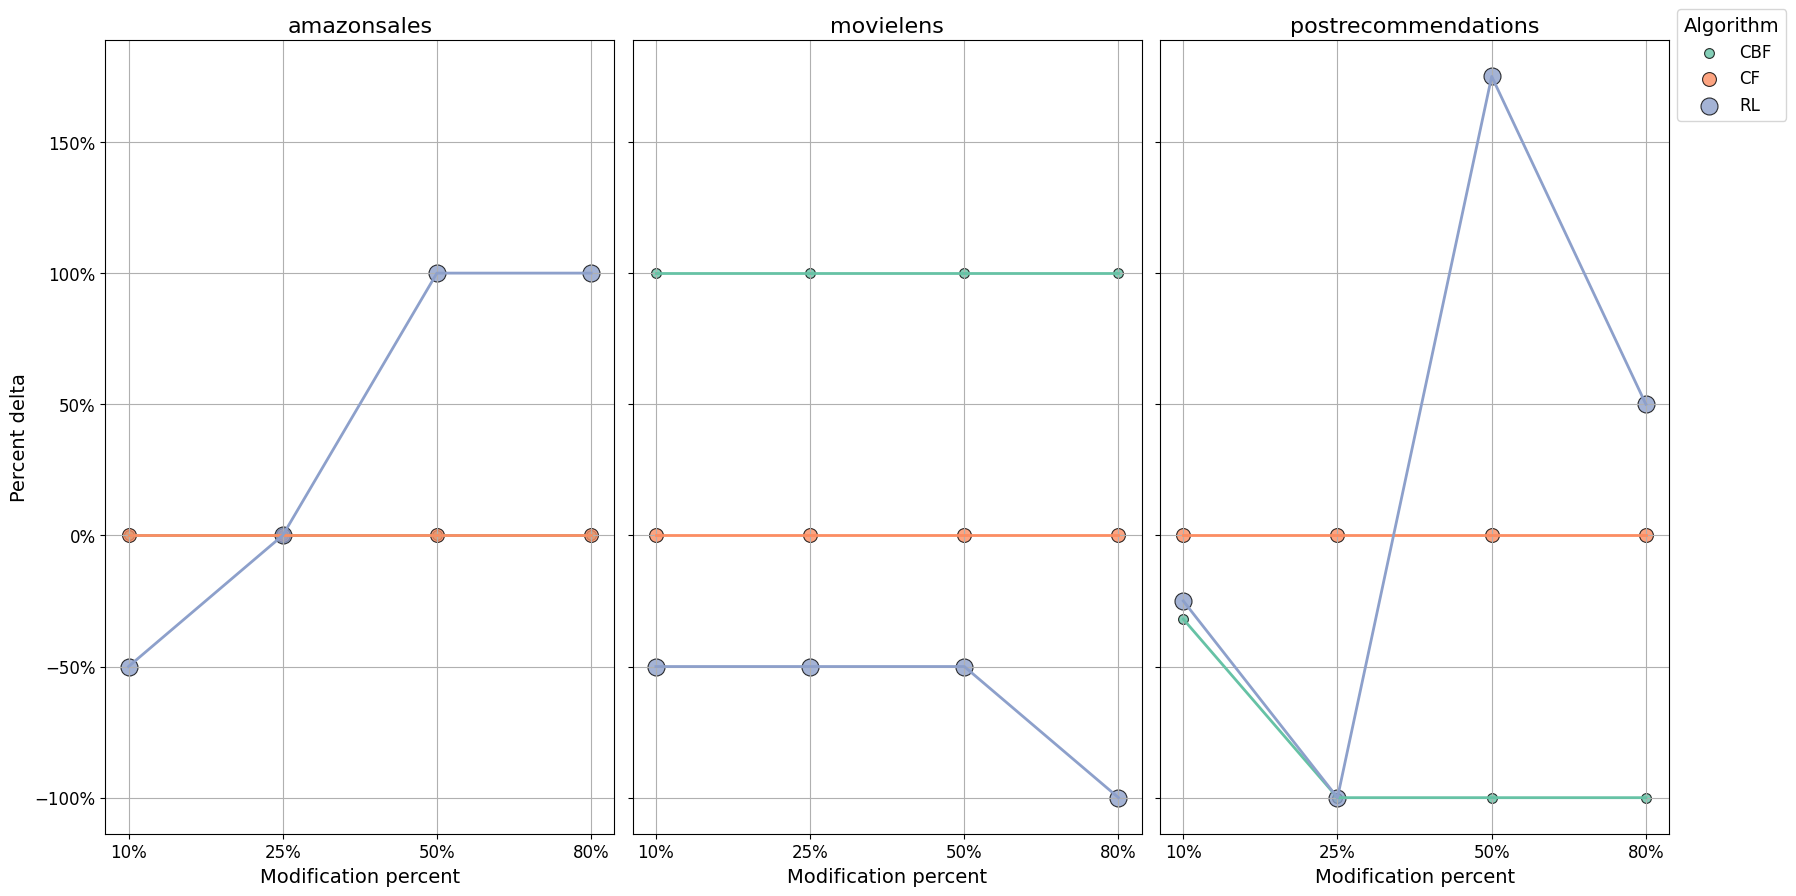

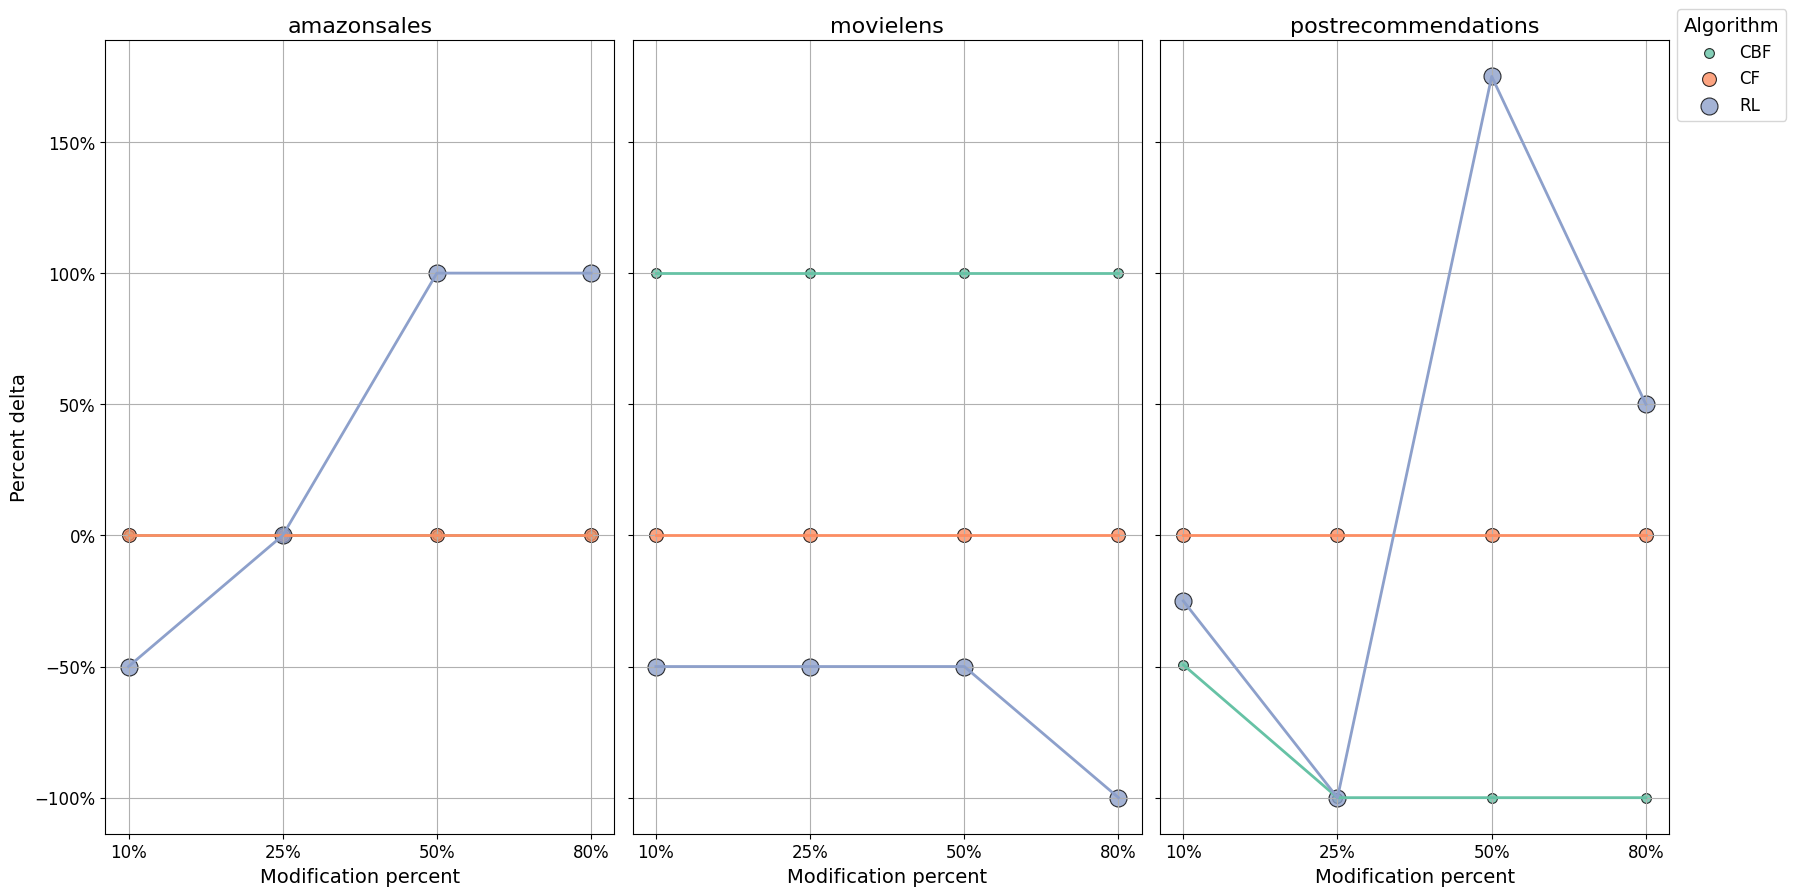

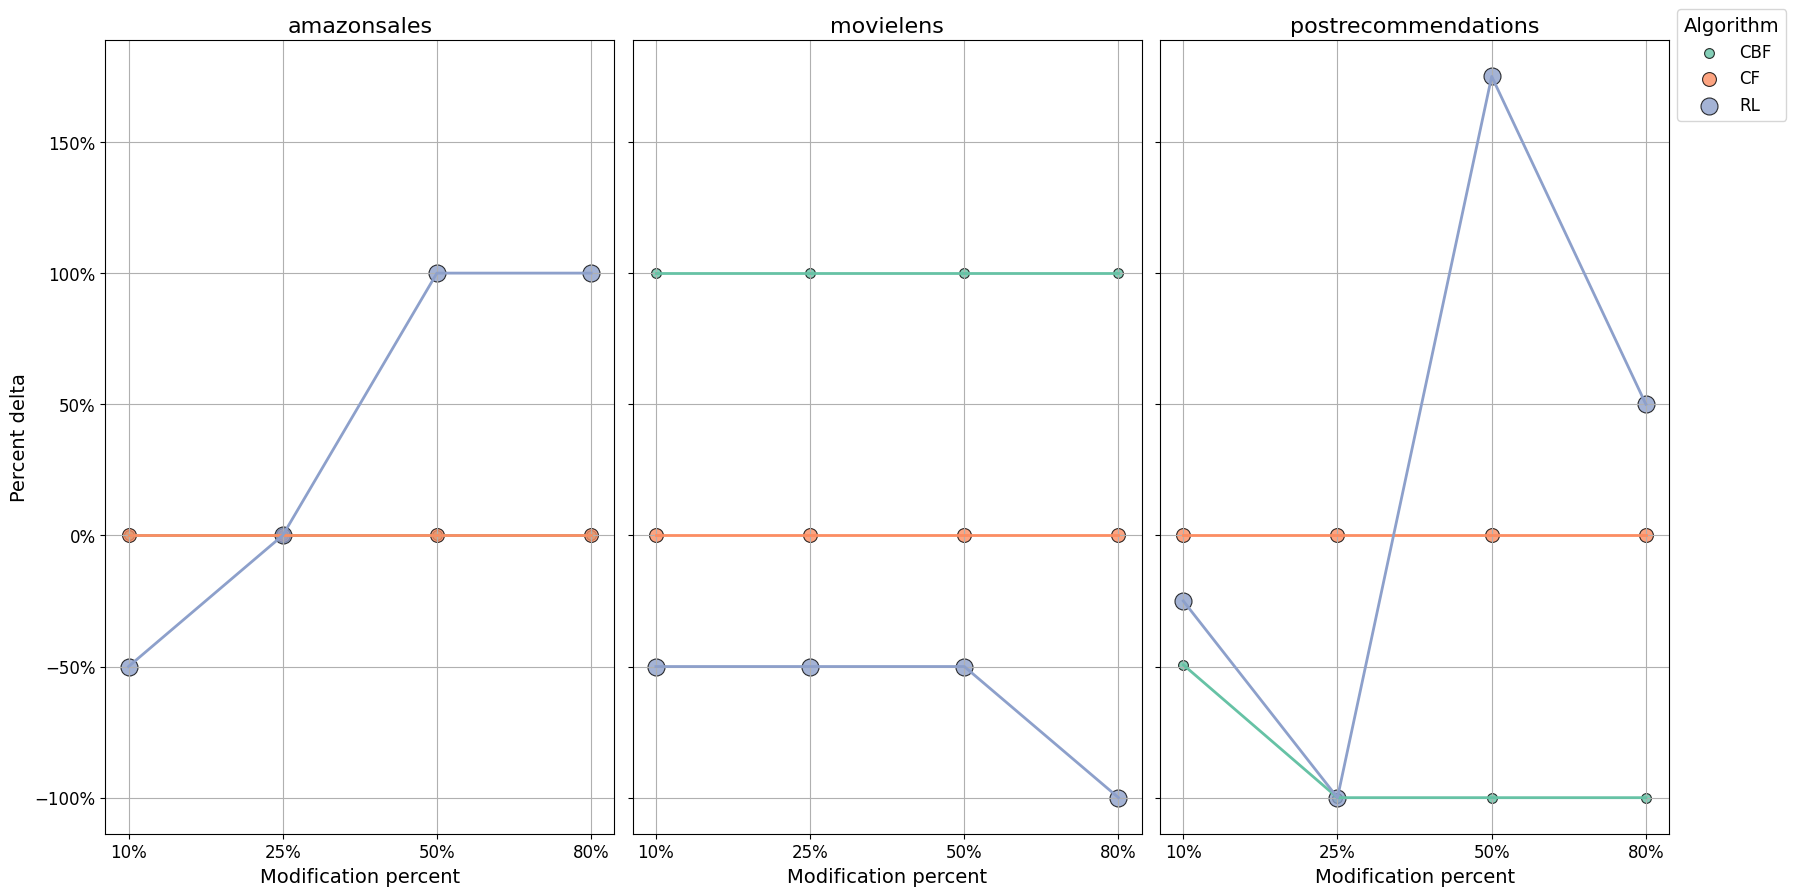

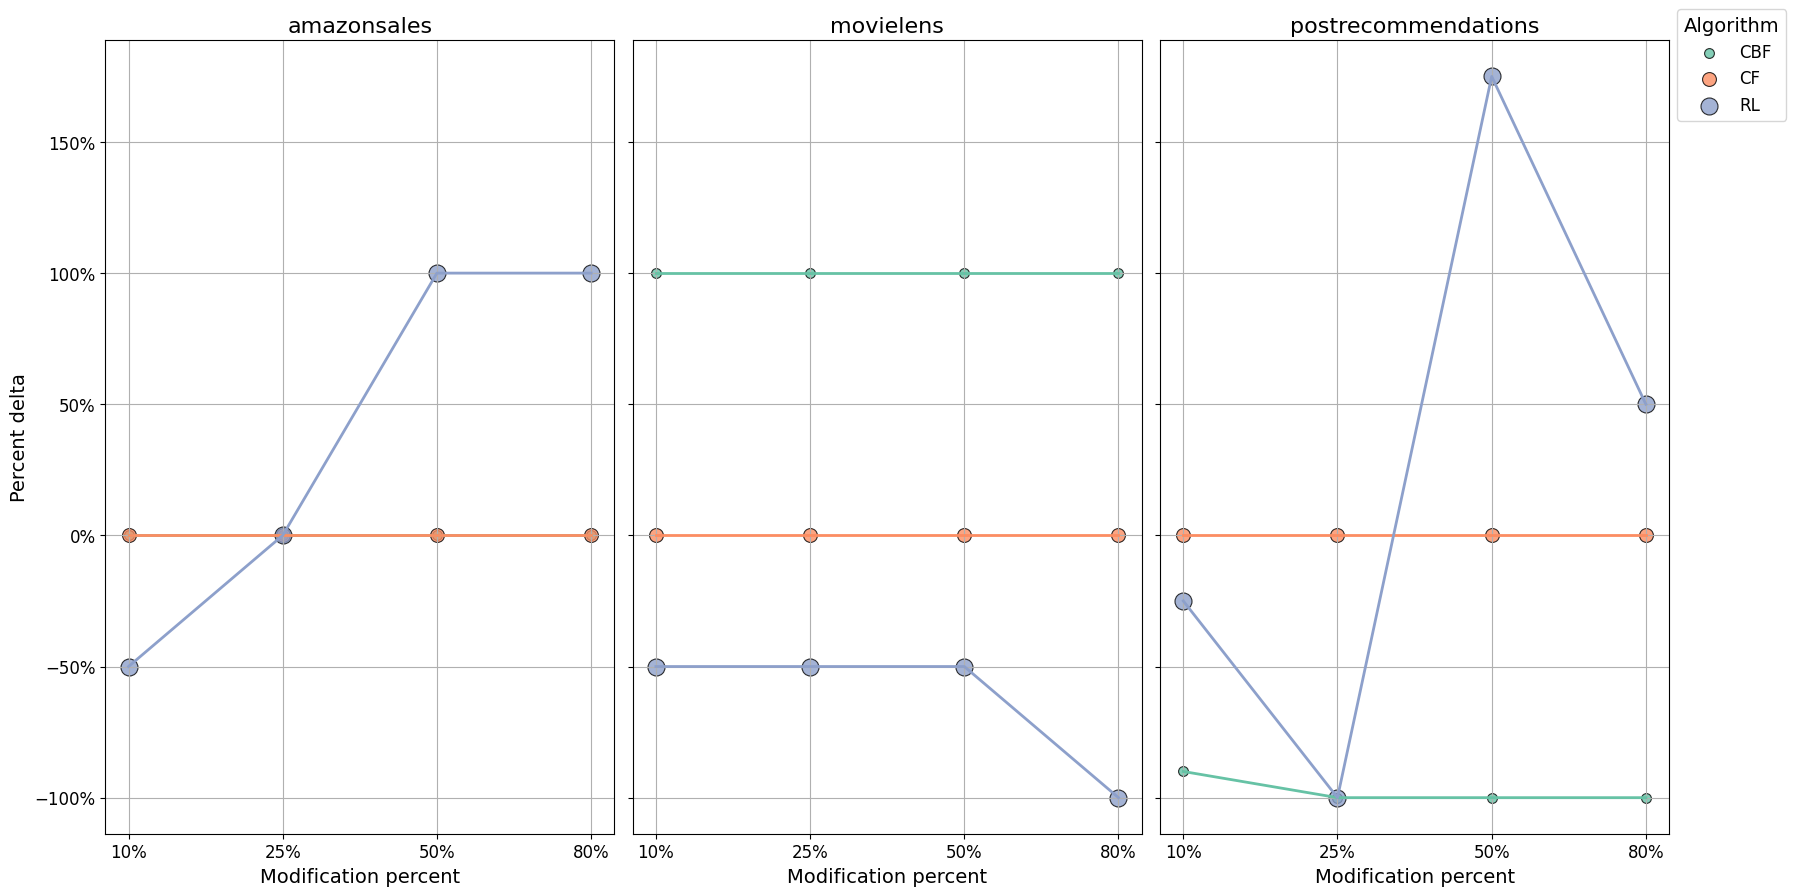

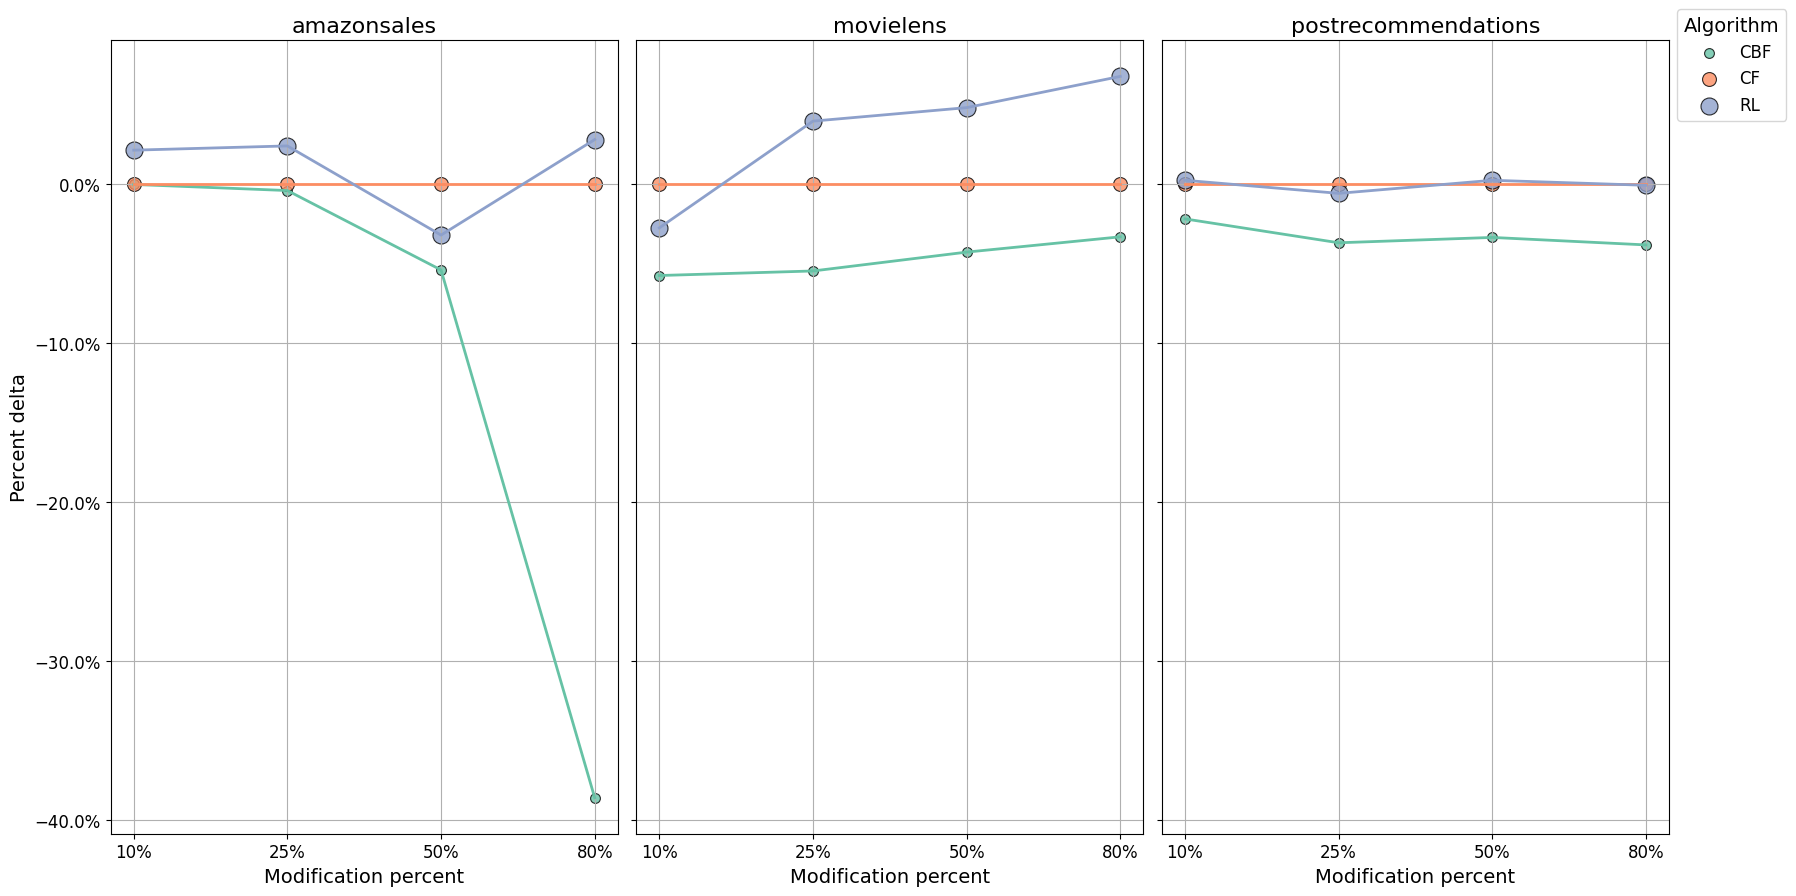

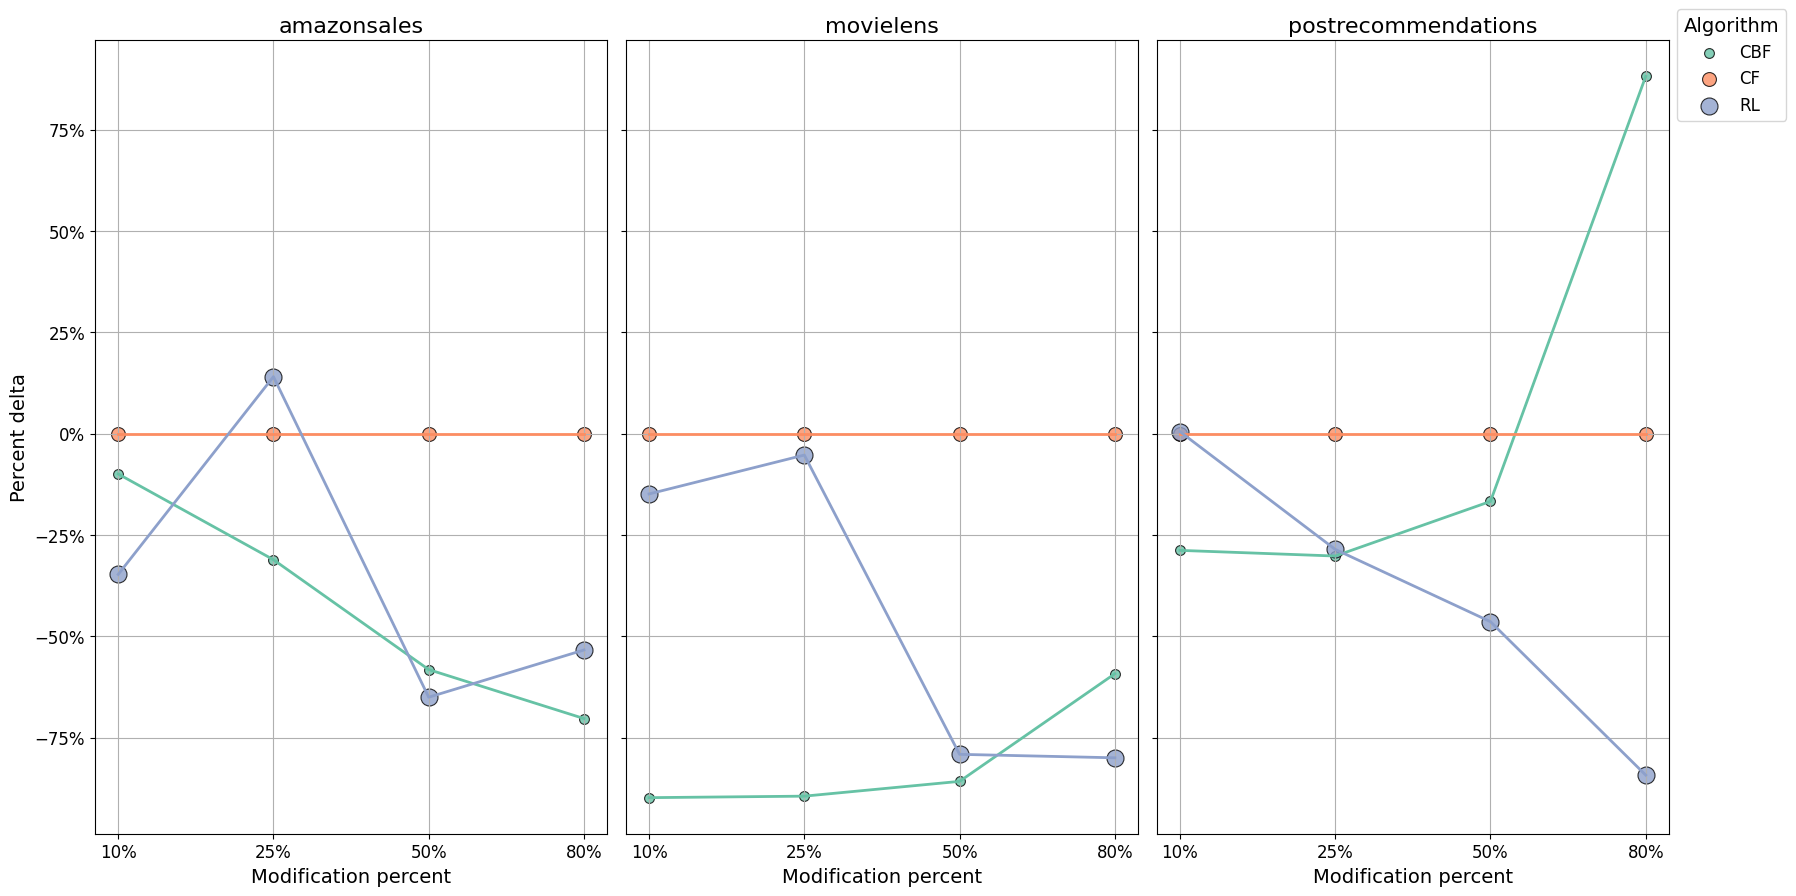

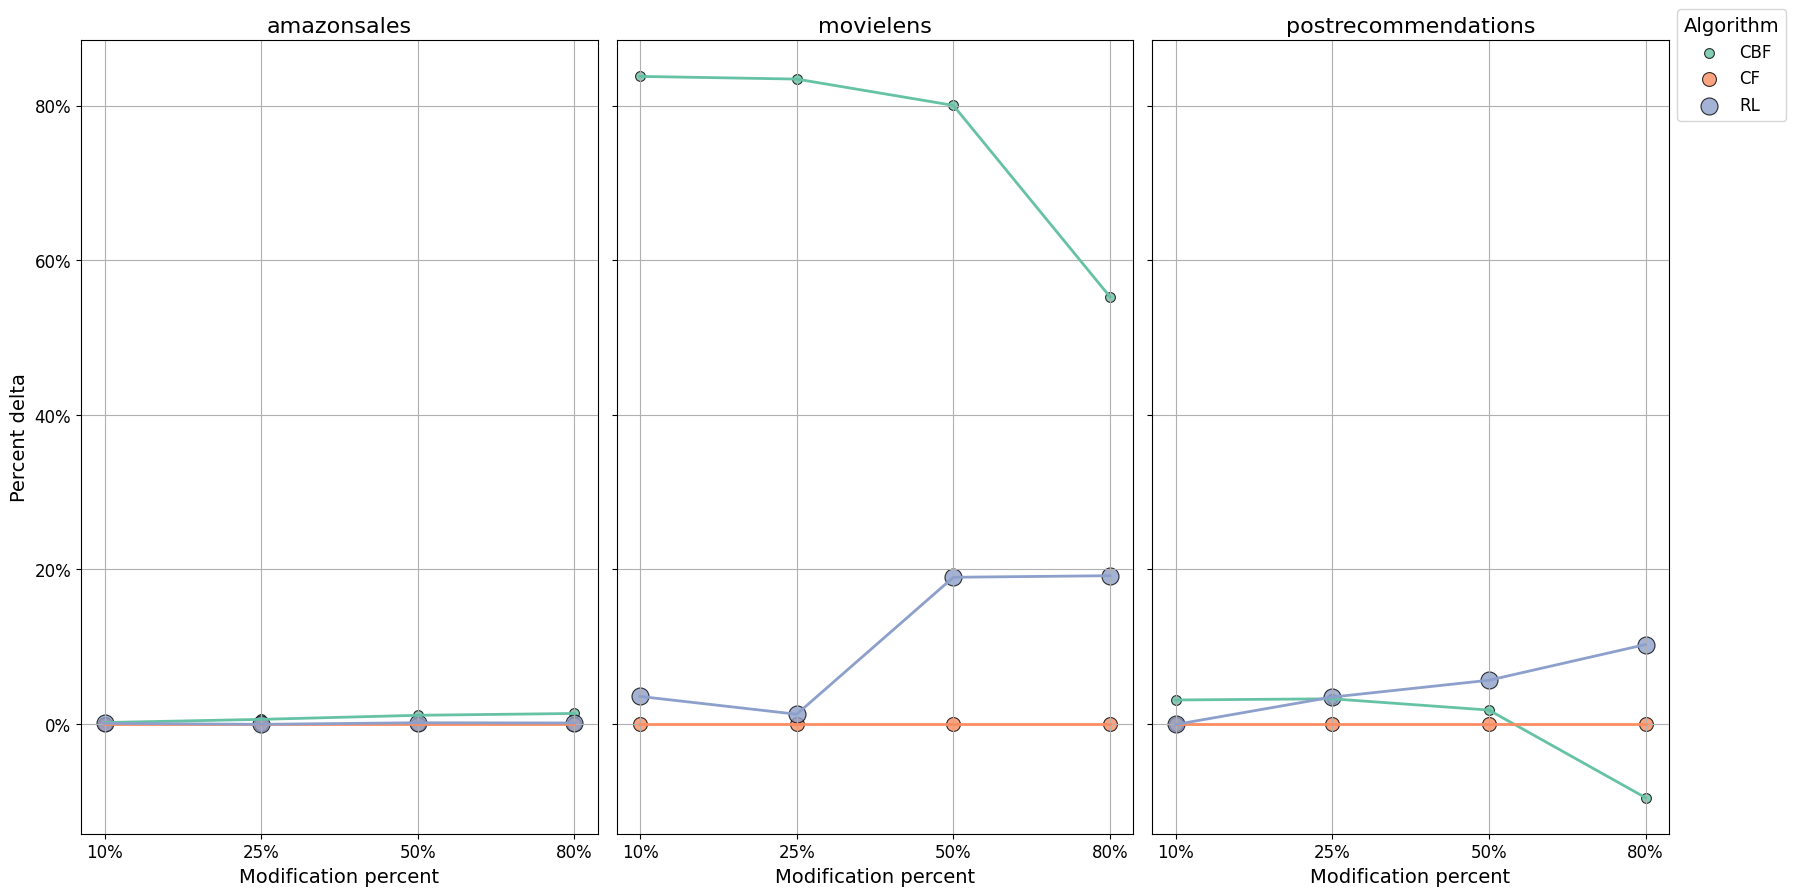

In [310]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

df = specific_df.copy()
df['combo'] = df['algorithm'] + ' - ' + df['dataset']

algorithms = df['algorithm'].unique()
datasets = df['dataset'].unique()

palette = sns.color_palette("Set2", n_colors=len(algorithms))
algorithm_colors = dict(zip(algorithms, palette))

# Przypisz rozmiary kropek dla algorytmów (np. rosnące liczby)
algorithm_sizes = {
    alg: size for alg, size in zip(algorithms, [50, 100, 150, 200, 250])  # dopasuj liczbę do liczby algorytmów
}

for key in df['key'].unique():
    key_subset = df[df['key'] == key]

    fig, axes = plt.subplots(1, 3, figsize=(18, 9), sharey=True)
    
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        dataset_subset = key_subset[key_subset['dataset'] == dataset]

        for alg in algorithms:
            alg_subset = dataset_subset[dataset_subset['algorithm'] == alg]
            base_color = algorithm_colors[alg]
            size = algorithm_sizes.get(alg, 50)  # domyślny rozmiar, gdy brak w słowniku

            ax.scatter(
                alg_subset['percent'],
                alg_subset['percent_delta'],
                s=size,               # 's' to powierzchnia kropki
                label=alg,
                color=base_color,
                edgecolor='black',
                linewidth=0.8,
                alpha=0.8,
                marker='o'
            )

            # Pogrubiona linia łącząca punkty
            ax.plot(
                alg_subset['percent'],
                alg_subset['percent_delta'],
                color=base_color,
                linewidth=2
            )

        ax.set_title(f"{dataset}", fontsize=16)
        ax.set_xlabel("Modification percent", fontsize=14)
        ax.tick_params(axis='both', labelsize=12)
        ax.grid(True)
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
        if i == 0:
            ax.set_ylabel("Percent delta", fontsize=14)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Algorithm",
        title_fontsize=14,
        fontsize=12,
        bbox_to_anchor=(0.93, 1),
        loc='upper left'
    )

    plt.tight_layout()
    plt.subplots_adjust(right=0.93)
    plt.show()


In [289]:
if not specific:
    metrics_to_plot = ['personalization', 'intra_list_dissimilarity']

    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df[merged_df['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )

        ax.legend_.remove()

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            height = p.get_height()
            algo = row['algorithm']
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10, color='black'
                )
        if metric == 'personalization':
            metric = 'Inter-diversity'
        elif metric == 'intra_list_dissimilarity':
            metric = 'Intra-list dissimilarity'
        ax.set_ylabel(metric)  # etykieta osi Y
        ax.set_xlabel('Dataset')  # etykieta osi X
        ax.set_ylim(0, 1)  # limit osi Y od 0 do 1
        ax.set_yticks([i/10 for i in range(11)])
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/personalization_intra_list_dissimilarity.png')
    plt.savefig(f'{folder_path}/fig/between_intra_dissimilarity.png')
    plt.show()

In [290]:
if not specific:
    metrics_to_plot = ['item_coverage', 'user_coverage']

    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df[merged_df['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )

        ax.legend_.remove()

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            height = p.get_height()
            algo = row['algorithm']
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10, color='black'
                )
        if metric == 'item_coverage':
            metric = 'Item coverage'
        elif metric == 'user_coverage':
            metric = 'User coverage'
        ax.set_ylabel(metric)  # etykieta osi Y
        ax.set_xlabel('Dataset')  # etykieta osi X
        ax.set_ylim(0, 1)  # limit osi Y od 0 do 1
        ax.set_yticks([i/10 for i in range(11)])
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/item_user_coverage.png')
    plt.show()

In [291]:
if not specific:
    metrics_to_plot = ['mae', 'rmse']

    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df[merged_df['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )

        ax.legend_.remove()

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            height = p.get_height()
            algo = row['algorithm']
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10, color='black'
                )
        if metric == 'mae':
            metric = 'MAE'
        elif metric == 'rmse':
            metric = 'RMSE'
        ax.set_ylabel(metric)  # etykieta osi Y
        ax.set_xlabel('Dataset')  # etykieta osi X
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/mae_rmse.png')
    plt.show()

In [292]:
if not specific:
    metrics_to_plot = ['mrr', 'ndcg_at_k']

    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))  # bez sharey=True

    for ax, metric in zip(axes, metrics_to_plot):
        df_metric = merged_df[merged_df['key'] == metric]

        sns.barplot(
            data=df_metric,
            x='dataset',
            y='value',
            hue='algorithm',
            palette='Set2',
            ax=ax
        )

        ax.legend_.remove()

        for p, (_, row) in zip(ax.patches, df_metric.iterrows()):
            height = p.get_height()
            algo = row['algorithm']
            if not pd.isna(height):
                ax.annotate(
                    algo,
                    (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom',
                    fontsize=10, color='black'
                )
        ax.set_ylim(0, 1)
        if metric == 'ndcg_at_k':
            metric='NDCG'
        elif metric == 'mrr':
            metric='MRR'
        ax.set_ylabel(metric)  # etykieta osi Y
        ax.set_xlabel('Dataset')  # etykieta osi X
        ax.set_ylim(0, 1)  # limit osi Y od 0 do 1
        ax.set_yticks([i/10 for i in range(11)])
        ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/mrr_ndcg.png')
    plt.show()

In [293]:
if not specific:
    fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=False)

    df_precision = merged_df[merged_df['key'] == 'precision']
    df_precision_at_k = merged_df[merged_df['key'] == 'precision_at_k']

    ax = axes[0]
    sns.barplot(
        data=df_precision,
        x='dataset',
        y='value',
        hue='algorithm',
        palette='Set2',
        ax=ax
    )
    ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    bar_colors = [patch.get_facecolor() for patch in handles]
    algo_colors = dict(zip(labels, bar_colors))

    for p, (_, row) in zip(ax.patches, df_precision_at_k.iterrows()):
        height = p.get_height()
        algo = row['algorithm']
        if not pd.isna(height):
            base_color = algo_colors.get(algo, (0.5, 0.5, 0.5, 1.0))
            lighter_color = mcolors.to_rgba(base_color)
            lighter_rgb = mcolors.to_rgb(lighter_color[:3])
            lighter_rgb = mcolors.to_rgba([min(1, c + 0.4*(1-c)) for c in lighter_rgb])

            ax.bar(
                p.get_x() + p.get_width() / 2,
                row['value'] - height,
                width=p.get_width(),
                bottom=height,
                align='center',
                color=lighter_rgb,
                edgecolor='none'
            )
            ax.annotate(
                algo,
                (p.get_x() + p.get_width() / 2, row['value']),
                ha='center', va='bottom',
                fontsize=10, color='black'
            )
    ax.set_ylabel('Precision')
    ax.set_xlabel('Dataset')
    ax.set_ylim(0, 1)
    ax.set_yticks([i/10 for i in range(11)])
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    # Recall plot
    df_recall = merged_df[merged_df['key'] == 'recall']
    df_recall_at_k = merged_df[merged_df['key'] == 'recall_at_k']

    ax = axes[1]
    sns.barplot(
        data=df_recall,
        x='dataset',
        y='value',
        hue='algorithm',
        palette='Set2',
        ax=ax
    )
    ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    bar_colors = [patch.get_facecolor() for patch in handles]
    algo_colors = dict(zip(labels, bar_colors))

    for p, (_, row) in zip(ax.patches, df_recall_at_k.iterrows()):
        height = p.get_height()
        algo = row['algorithm']
        if not pd.isna(height):
            base_color = algo_colors.get(algo, (0.5, 0.5, 0.5, 1.0))
            lighter_color = mcolors.to_rgba(base_color)
            lighter_rgb = mcolors.to_rgb(lighter_color[:3])
            lighter_rgb = mcolors.to_rgba([min(1, c + 0.4*(1-c)) for c in lighter_rgb])

            ax.bar(
                p.get_x() + p.get_width() / 2,
                row['value'] - height,
                width=p.get_width(),
                bottom=height,
                align='center',
                color=lighter_rgb,
                edgecolor='none'
            )
            ax.annotate(
                algo,
                (p.get_x() + p.get_width() / 2, row['value']),
                ha='center', va='bottom',
                fontsize=10, color='black'
            )
    ax.set_ylabel('Recall')
    ax.set_xlabel('Dataset')
    ax.set_ylim(0, 1)
    ax.set_yticks([i/10 for i in range(11)])
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    plt.tight_layout()
    if save:
        plt.savefig(f'{folder_path}/fig/precision_recall.png')
    plt.show()